# Spectral Plots
Plot spectral segements and label the lines of particular elements in that segment

In [2]:
from __future__ import division # to get float division with ints

# Import readsav so we can read IDL Save Files
import warnings
from scipy.io import readsav
warnings.filterwarnings('ignore', message="warning: empty strings")

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import re

%matplotlib inline
mpl.rcParams['figure.figsize']=(16.,10.)
mpl.rcParams['font.size']=16
mpl.rcParams['font.weight']='bold'

# We could set this below using:
#   ax.tick_params(axis='both', which='both', direction='in', length=10, width=2, labelsize=16, bottom='on', left='on', right='on', top='on')
#   ax.tick_params(axis='both', which='major', length=20, width=4)
#   But this way we don't clutter up the plotting routine and just do everything once in the setup.
#
mpl.rcParams['axes.linewidth'] = 3.0

# set x tick size and width
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.minor.width'] = 1

# set tick width
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.minor.width'] = 1

# Speed of light for calculating offsets in wavelengths due to RV shifts
cLight = 299792.458 # km/s

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

def getColor(i):
    return tableau20[i % len(tableau20)]

# Define colors that we will use for plot backgrounds, axes, and text
#  use fig.patch.set_alpha(0.0) to make _figure_ background transparent.
#
bgColor='#ffffff'
txtColor='#191919' # Dark Grey, blue for presentations == #7EA2B0
axisColor = '#191919'

In [1]:
specs = [
    {'name':'HD 240430', 'dir': '../data/240430_rj211.85/'},
    {'name': 'HD 240429', 'dir': '../data/240429_rj211.86/'},
    ]

In [3]:
def lineColor(elem):
    coloredElems = ['Mg','Fe','Ti','Na','O','Ni','C','Cr','Ca','Mn']
    if elem in coloredElems:
        cIdx = coloredElems.index(elem)
    else:
        return getColor(14) # dark grey
        
    lineColors = [
        {'elem': 'Mg', 'color': getColor(0)}, # dark blue
        {'elem': 'Fe', 'color': getColor(6)}, # dark red
        {'elem': 'Ti', 'color': getColor(1)}, # light blue
        {'elem': 'Na', 'color': getColor(16)}, # gold
        {'elem': 'O', 'color': getColor(4)}, # dark green
        {'elem': 'Ni', 'color': getColor(6)}, # light red
        {'elem': 'C', 'color': getColor(2)}, # dark orange
        {'elem': 'Cr', 'color': getColor(8)}, # dark purple
        {'elem': 'Si', 'color': getColor(0)}, # dark blue
        {'elem': 'Ca', 'color': getColor(18)}, # dark teal
        {'elem': 'Mn', 'color': getColor(2)}, # dark orange
    ]
    
    return (lineColors[cIdx])['color']

In [4]:
def plotSeg( spec, segIdx=0, wRange=[5170.,5175.], showLines=[], ax=None, yMin=0.0, showModel=True, outFile=None):
    # Speed of light for calculating offsets in wavelengths due to RV shifts
    cLight = 299792.458 # km/s
    OLine = 6300.3038
    OSpec = 'O I'
    # Get the indexes of the start/end of the wavelength region
    wIdxBeg = (np.where(spec.wave[0] >= wRange[0]))[0][0]
    wIdxEnd = (np.where(spec.wave[0] <= wRange[1]))[0][-1]
    
    # element abbr from species name
    speciesRE = re.compile("^([A-Za-z]+[0-9]*).*") # atoms and molecules but not ionization
    
    # This routine only plots one segment over the wavelength range given
    segLengths = wRange[1]-wRange[0]
    nSegments = 1
    
    # Y axis scale, leave room for line labels if any
    yMax = 1.05
    yDiff = yMax - yMin
    if len(showLines) > 0: yMax += (0.3 * yDiff)
    
    # For adding/labelling lines
    labelLineTop = yMax - (0.3 * yDiff)
    labelLineBot = yMax - (0.65 * yDiff) # for fixed depth labels
    labelTextBot = labelLineTop + (0.02 * yDiff)
    lineOffset = (0.05 * yDiff) # if using actual depths, offset line bottom by this amount from spectrum
    
    # Set line widths and colors for model and observation
    obsColor = '#999999' # Observation in dark grey
    obsWidth = 4
    modColor = getColor(0) # Model in dark blue
    modWidth = 4
    lineWidth = 1 # width of line label marker
    
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel("Wavelength",fontweight='bold')
        ax.set_ylabel("Residual Intensity",fontweight='bold')
        ax.get_xaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: "{:6.1f}".format(x)))
    
    ax.set_xlim(wRange)
    ax.set_ylim([yMin,yMax])
    
    # Now plot the MODEL spectrum...we are illustrating line shapes here, not showing
    #  match of model to observation.
    vrads = spec.vrad[0]
    if type(vrads) == np.float32:
        vrad = vrads
    else:
        vrad = vrads[segIdx]
    waveShift = 1.0 - vrad/cLight
    
    waves = spec.wave[0][wIdxBeg:wIdxEnd] * waveShift
    
    obs = spec.sob[0][wIdxBeg:wIdxEnd]
    mod = spec.smod[0][wIdxBeg:wIdxEnd]
    
    # Plot the observation
    pObs = ax.plot(waves,obs,linestyle='-',color=obsColor,linewidth=obsWidth)
    
    if showModel:
        # Plot the model
        pMod = ax.plot(waves,mod,linestyle='-',color=modColor,linewidth=modWidth)
    
    if len(showLines) > 0:
        # Grab atomic line information
        lines = spec.atomic[0]
        species = spec.species[0].astype(str)
        if lines.shape == (8,):
            lineWaves = np.array([lines[2]])
            manyLines = False
        else:
            lineWaves = lines[:,2]
            manyLines = True
        lineDepths = spec.depth[0]
        lineIdxs = np.array(range(len(lines)))
        
        # Add fake oxygen line at correct wavelength so we can plot it next to Ni line
        if manyLines:
            lineWaves = np.append(lineWaves,6300.3038)
            lineDepths = np.append(lineDepths,0.2)
            species = np.append(species,'O 1')
            
            s = np.argsort(lineWaves)
            lineWaves = lineWaves[s]
            lineDepths = lineDepths[s]
            species = species[s]
            lineIdxs = np.array(range(len(lineWaves)))
            
        # wavelengths will be centers of lines
        # Look for the wave between wave and wave +- 0.005
        minLineSep = 0.02
        prevLine = 0.0
        
        for wave,aType in showLines:
            boolIdxs = (lineWaves >= wave - 0.005) & (lineWaves <= wave + 0.005) & (species == aType)
            if np.sum(boolIdxs) == 0:
                print("Not Found",wave,aType)
                continue

            if manyLines:
                idx = lineIdxs[boolIdxs][0]
            else:
                idx = 0
            
            elem = speciesRE.match(species[idx])
            lColor = lineColor(elem.group(1))
            lWave = lineWaves[idx] # wavelength center from atomic line parameters
            if lWave <= (prevLine + 2*minLineSep): continue
            
            if lWave <= (prevLine + 4.*minLineSep):
                hAlign = 'left'
            else:
                hAlign = 'center'
                
            prevLine = lWave
            
            wavesOfInterest = (waves >= (lWave - minLineSep)) & (waves <= (lWave + minLineSep))
            if np.sum(wavesOfInterest) == 0: continue
            
            lBot = np.min(mod[wavesOfInterest]) + lineOffset
            p = ax.plot([lWave,lWave],[lBot,labelLineTop],linestyle='-',color=lColor,linewidth=lineWidth)
            pt = ax.text(lWave,labelTextBot,"{} - {:8.3f}".format(species[idx],lWave),
                   horizontalalignment=hAlign,verticalalignment='bottom',
                   rotation=90,
                   fontweight='bold',fontsize=12,color=lColor)
    
    if outFile != None:
        fig.savefig(outFile,bbox_inches="tight")
    
    return 0

In [10]:
def getGoodSegs( smeFile, elem ):
    # return counts of # lines of elem in each segment
    spec = (readsav(smeFile)).sme
    
    # Grab the line information
    lines = spec.atomic[0]
    lineWaves = lines[:,2]
    species = spec.species[0].astype(str)
    depths = spec.depth[0]
    
    # Find the segments which have 'elem' in them
    elemLines = ( species == '{} 1'.format(elem) )
    if np.sum(elemLines) == 0:
        return segs
    
    # get the indexes of all the lines for this element
    eIdxs = (np.array(range(len(lines))))[elemLines]
    eWaves = lineWaves[elemLines]
    
    # Determine if segment has any lines of this element, store the count in segs array
    wran = spec.wran[0] # wavelength ranges of segments
    segs = np.zeros(len(wran))
    for idx,waveRange in enumerate(wran):
        segs[idx] = np.sum((eWaves > waveRange[0]) & (eWaves < waveRange[1]))
    
    return segs

def getLinesToMark( smeFile, seg, elem ):
    # return counts of # lines of elem in each segment
    spec = (readsav(smeFile)).sme
    
    # Grab the line information
    lines = spec.atomic[0]
    lineWaves = lines[:,2]
    species = spec.species[0].astype(str)
    depths = spec.depth[0]
    wran = spec.wran[0] # wavelength ranges of segments
    
    waveRange = wran[seg] # specific wavelength range of the segment we wish to plot
    
    elemSpecies = '{} 1'.format(elem)
    minDepth = 0.25
    
    boolIdxs = ( ((lineWaves >= waveRange[0]) & (lineWaves <= waveRange[1]) & 
                (depths >= minDepth) & (species != 'MgH 1') & (species != 'Ru 1') & (species != 'Pr 2')
               & (species != 'Ce 2') & (species != 'Nd 2') & (species != 'Cr 1') & (species != 'CN 1')
                 & (species != 'C 2')) |
                ((lineWaves >= waveRange[0]) & (lineWaves <= waveRange[1]) & (species == elemSpecies)) )
    
    #print(lineWaves[boolIdxs])
    #print(species[boolIdxs])
    #print(depths[boolIdxs])
    #print(np.sum(boolIdxs))

    centers = lineWaves[boolIdxs]
    lSpecs = species[boolIdxs]
    markLines = list(zip(centers,lSpecs))
    
    return markLines

In [11]:
smeFile = '{}/iter1_abund.out'.format(specs[0]['dir'])
segs = getGoodSegs(smeFile,'Mn')

FileNotFoundError: [Errno 2] No such file or directory: '../data/240430_rj211.85//iter1_abund.out'

In [7]:
segs

array([  2.,   3.,   6.,   5.,   4.,   5.,  10.,  14.,   7.,   2.,  11.,
         4.,   3.,  11.,   2.,   1.,   0.,  25.,   0.,  17.])

/opt/anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


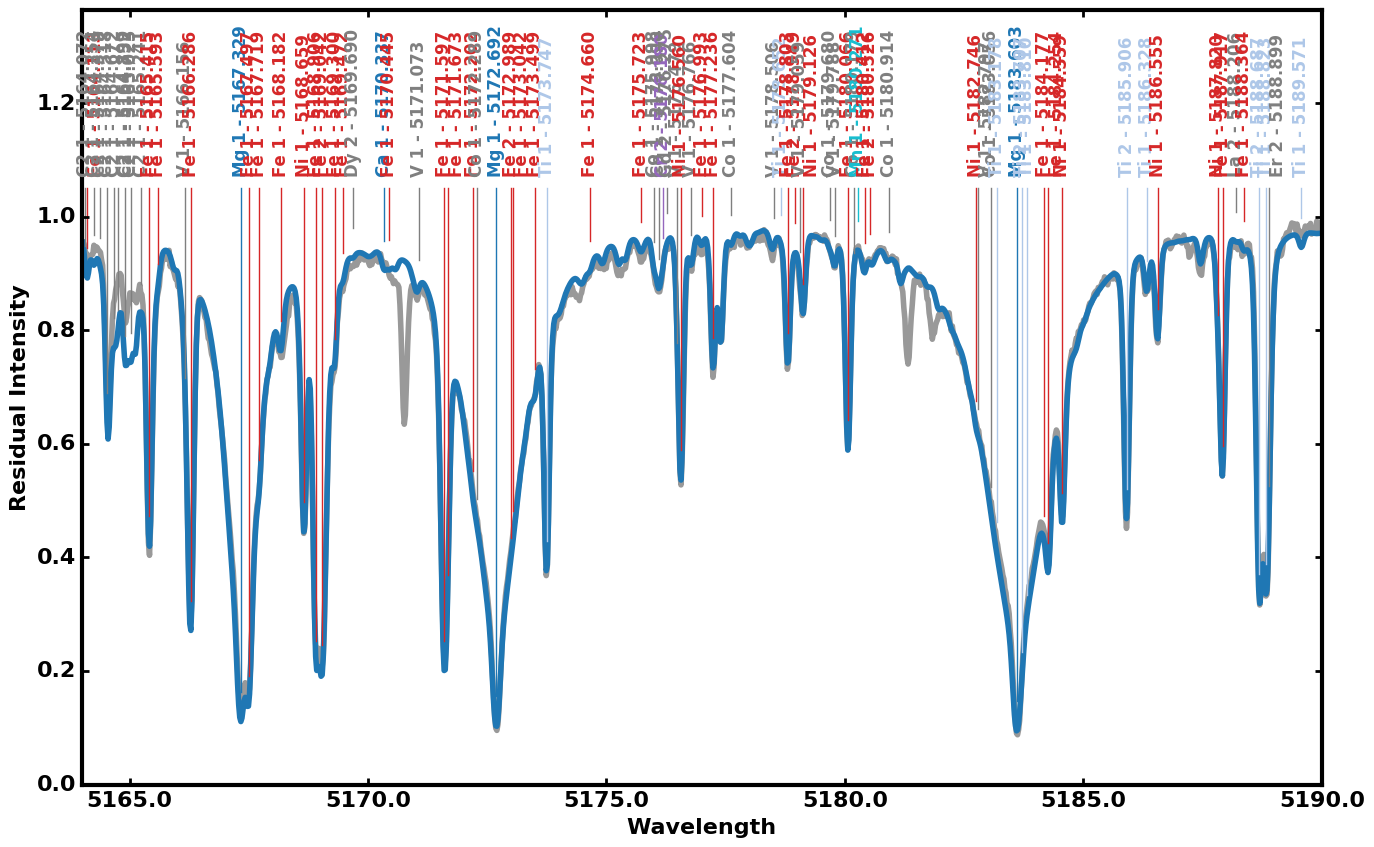

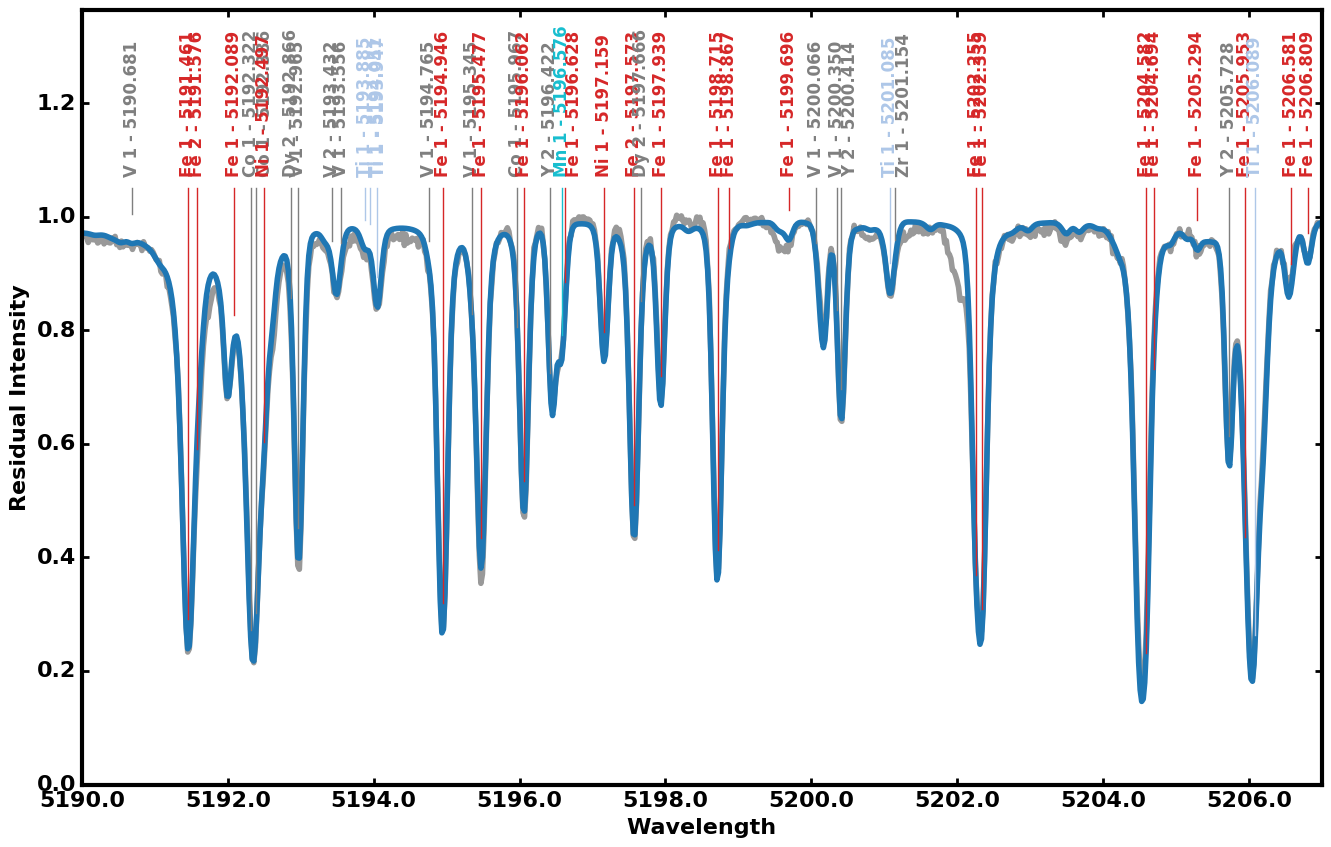

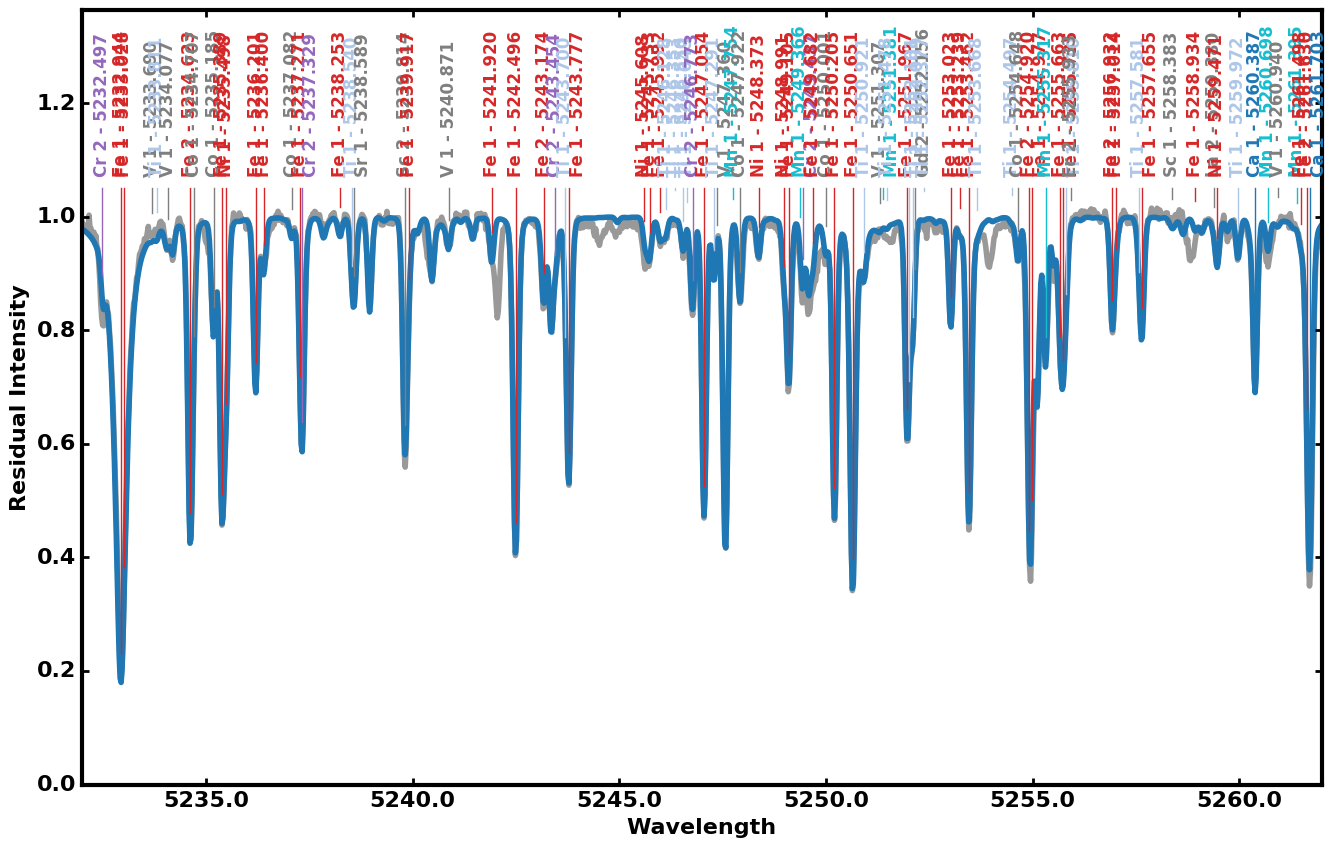

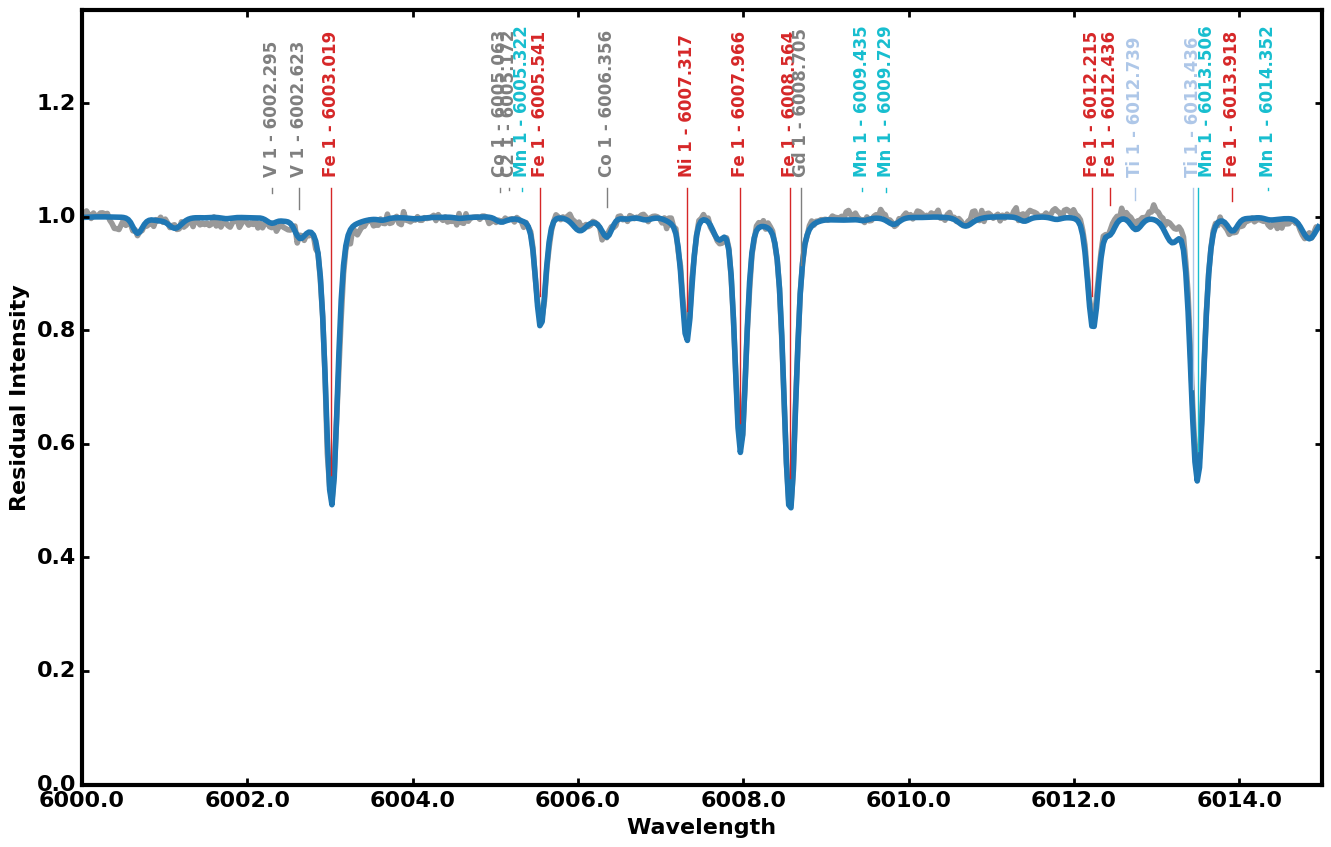

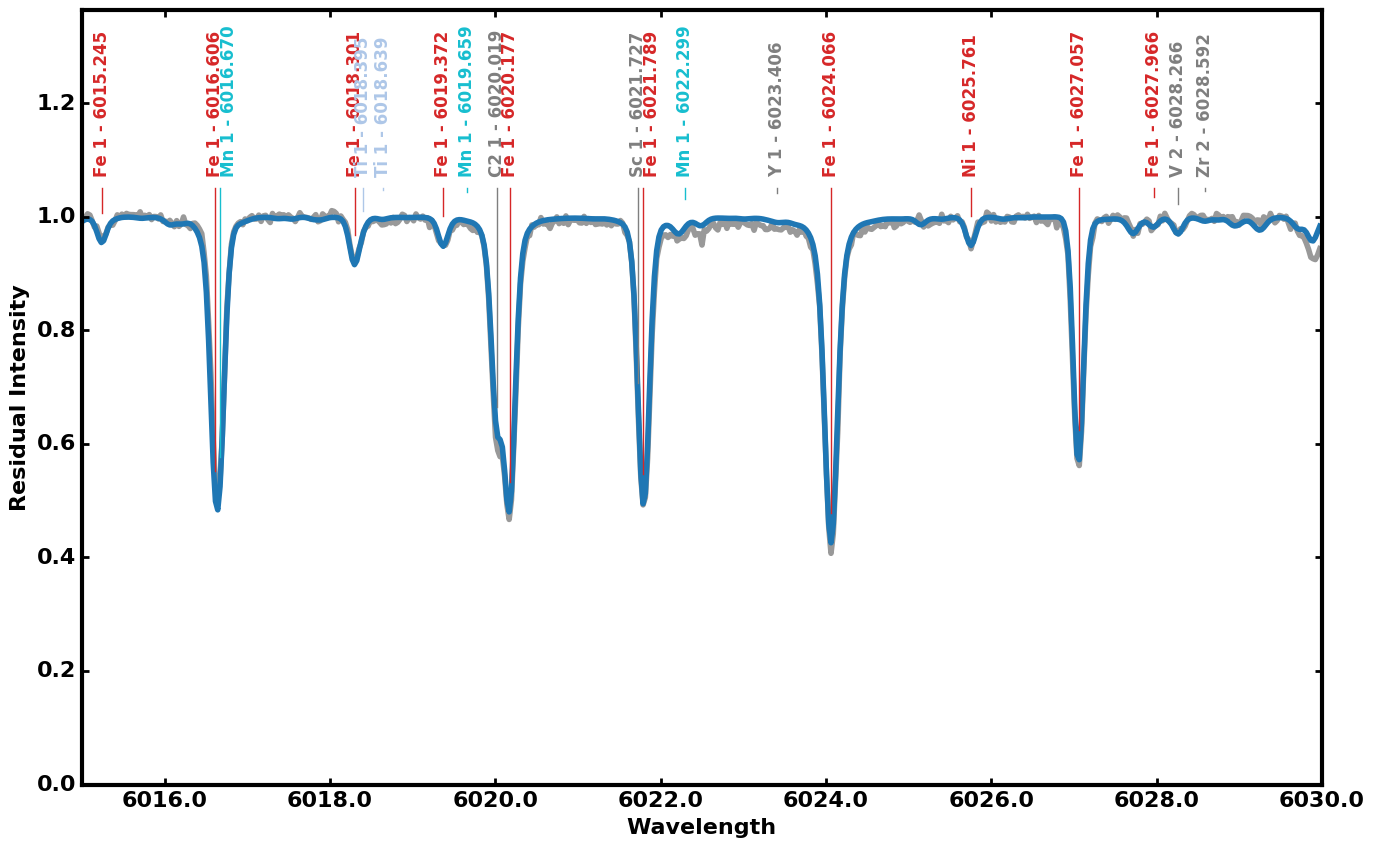

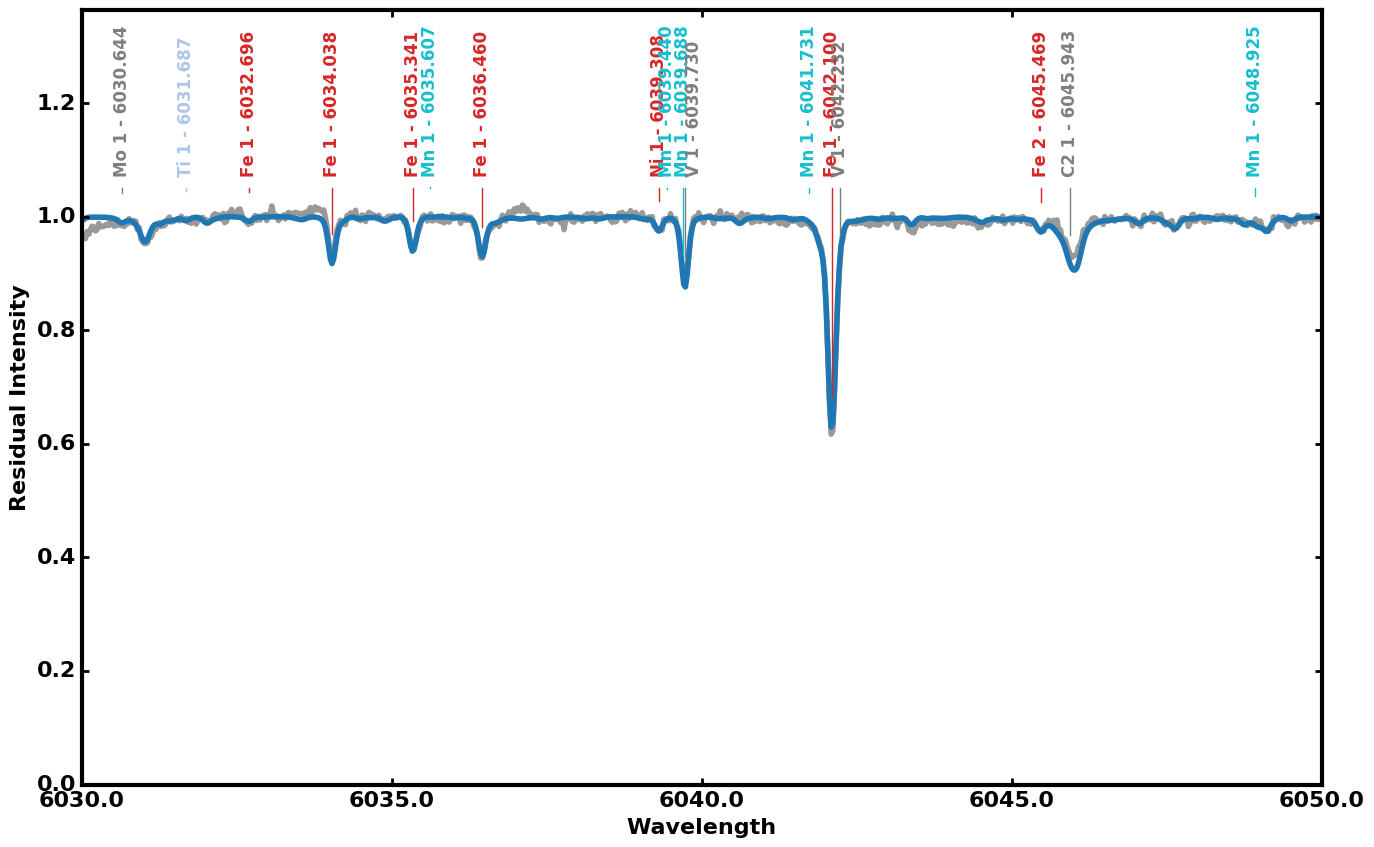

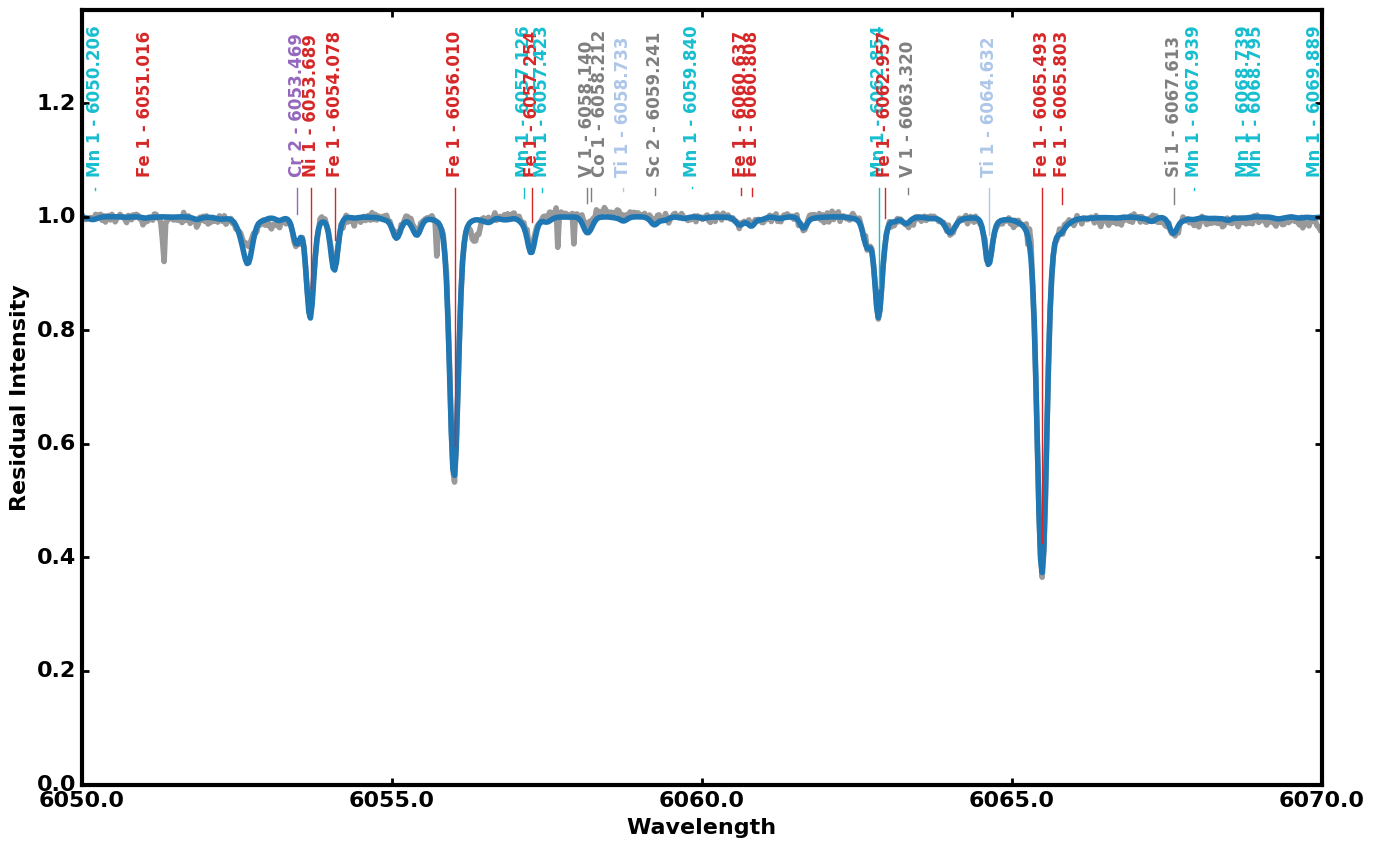

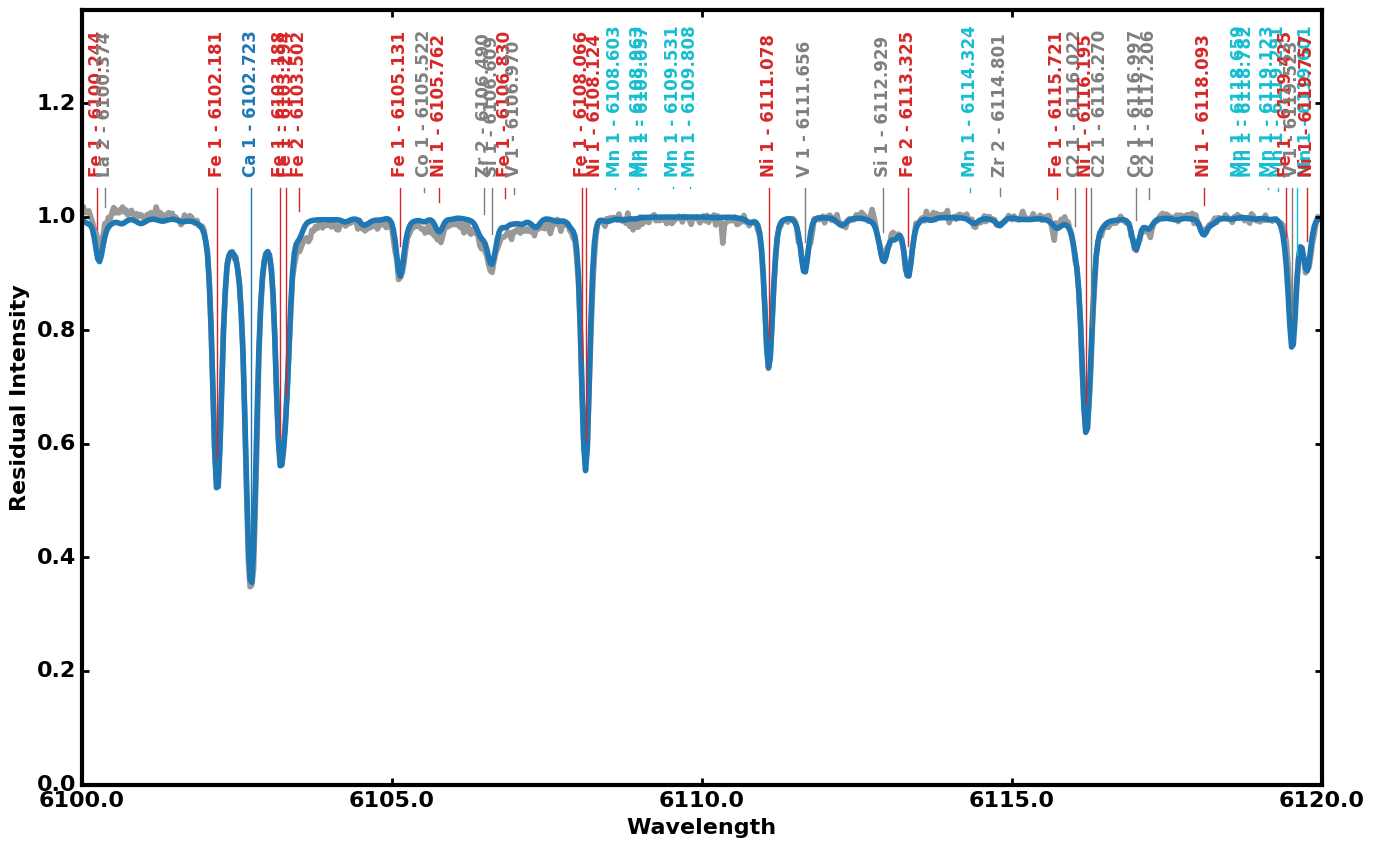

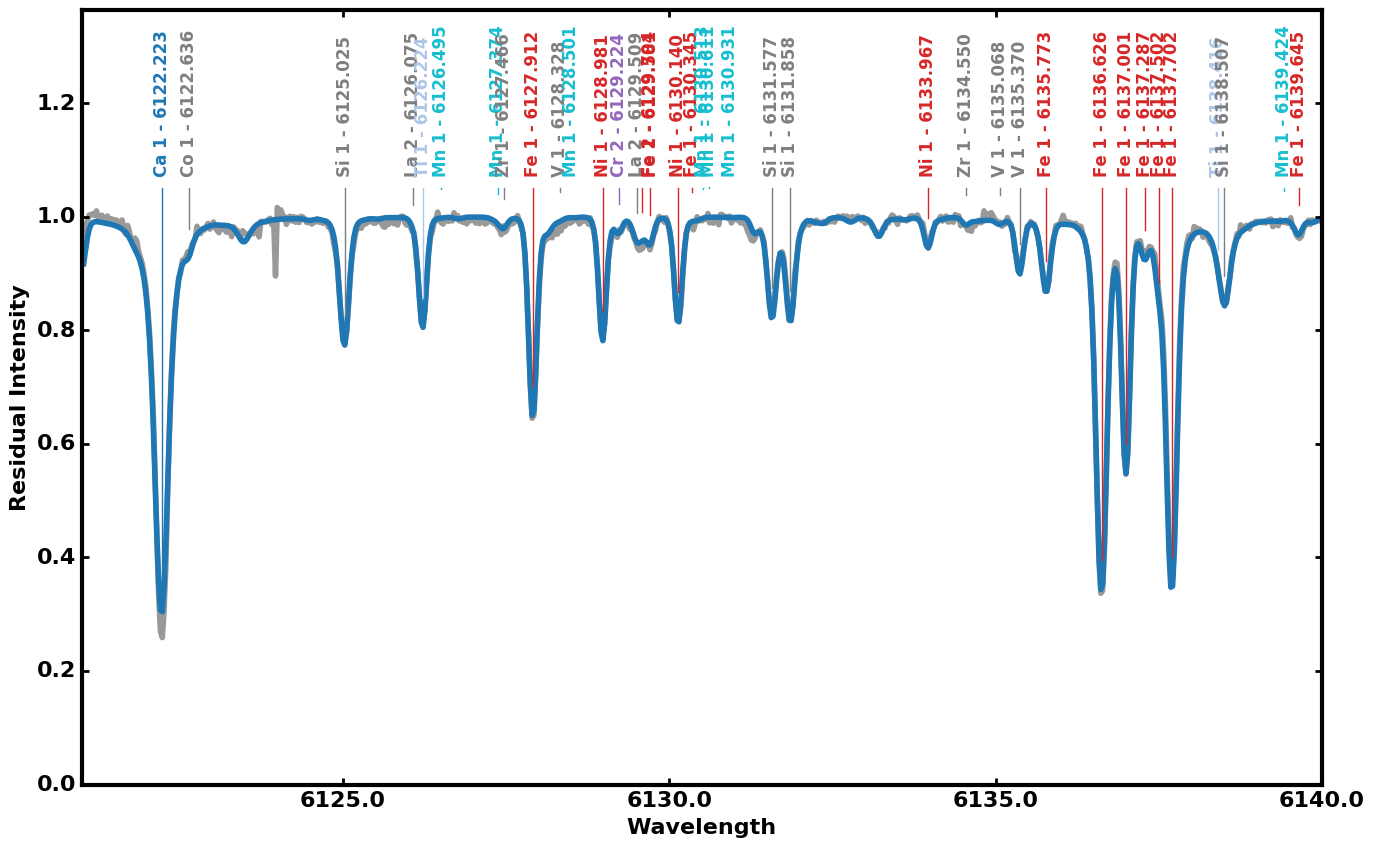

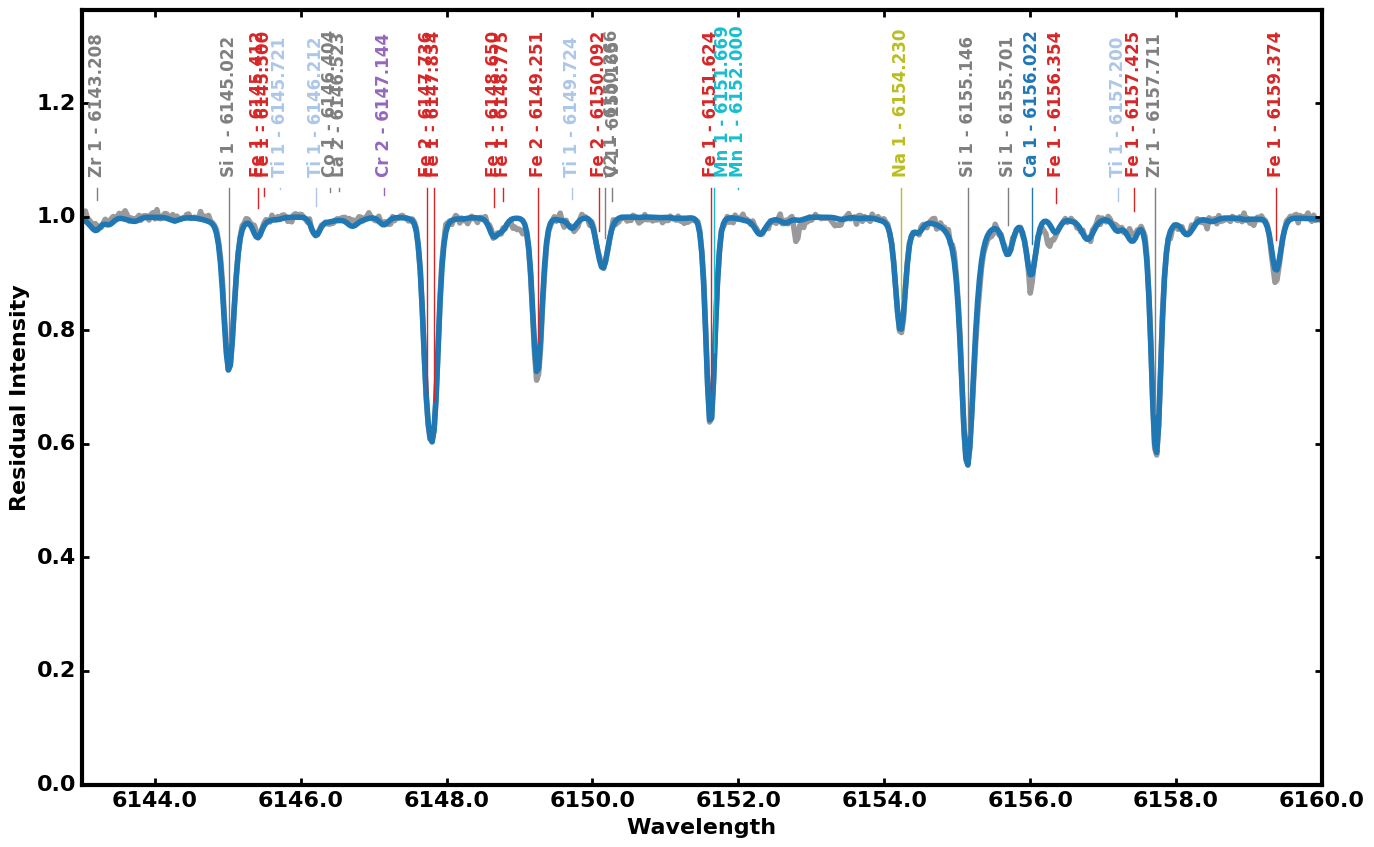

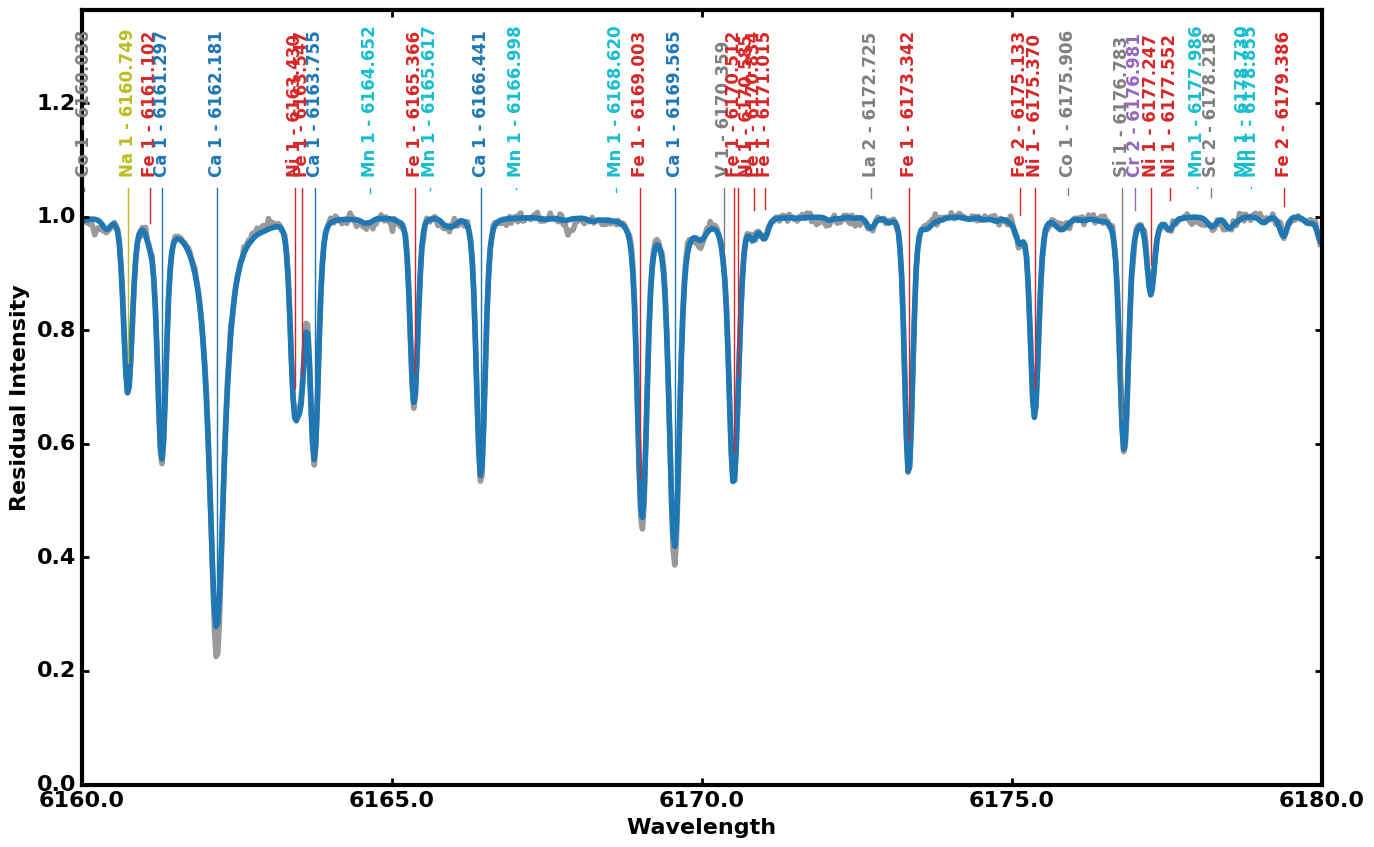

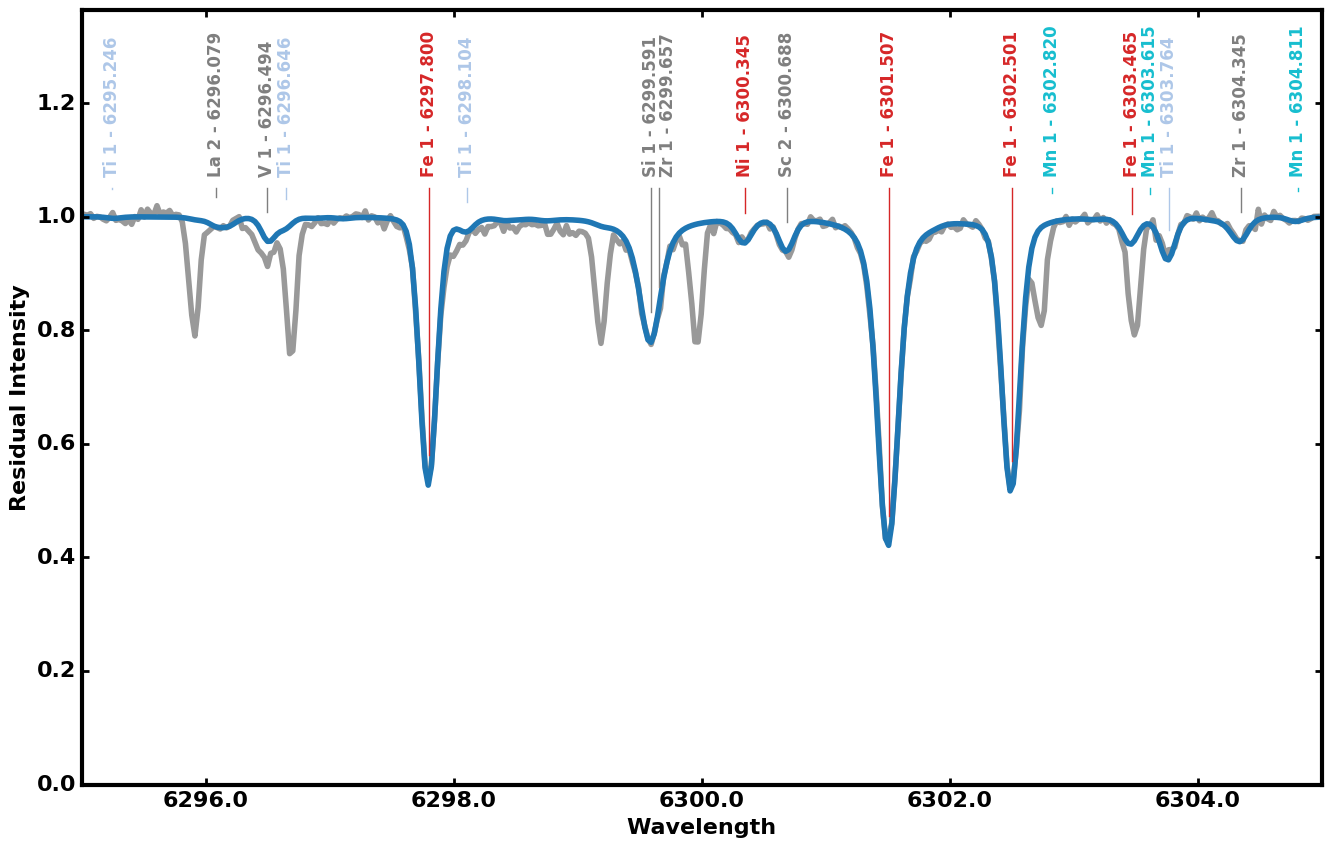

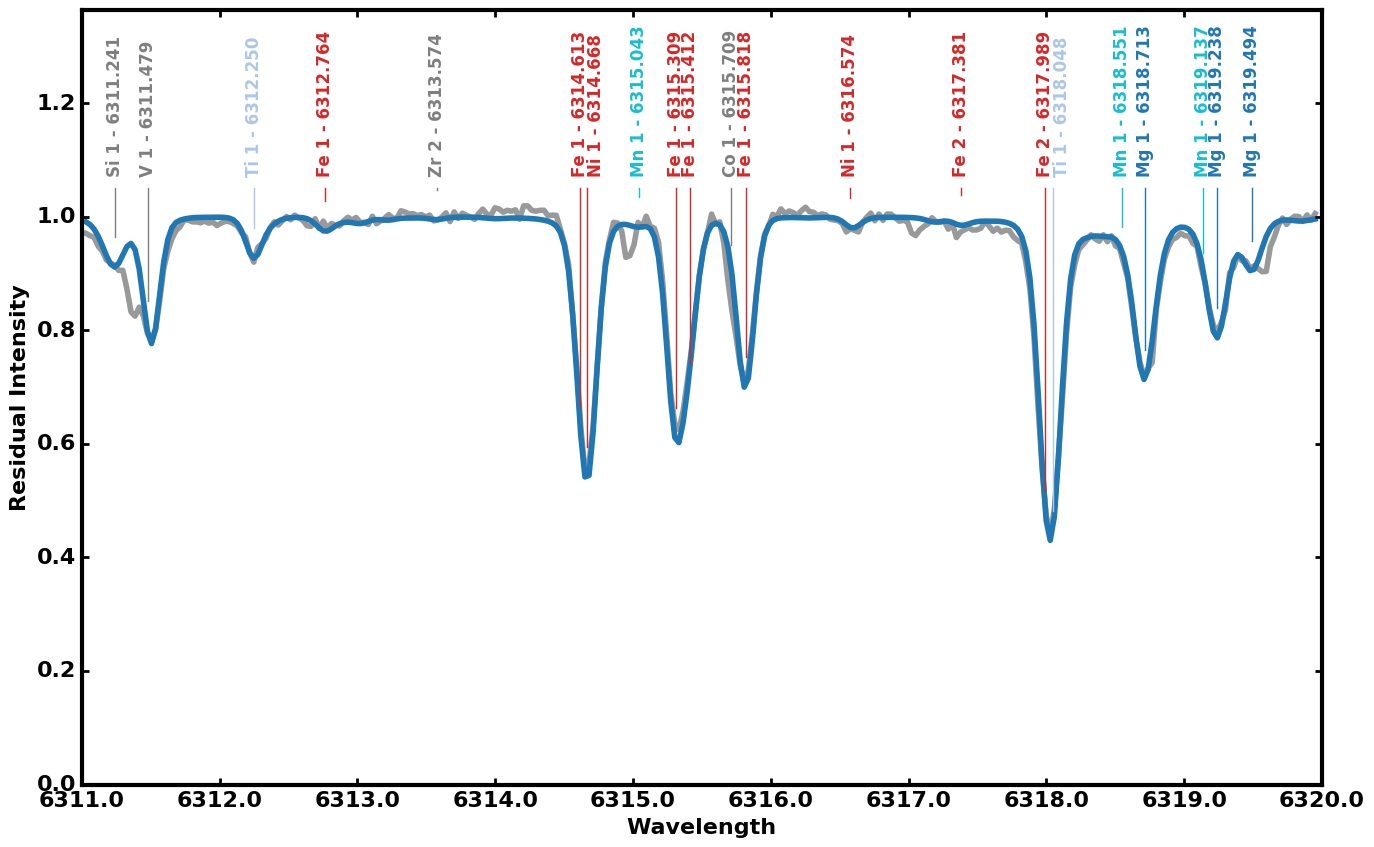

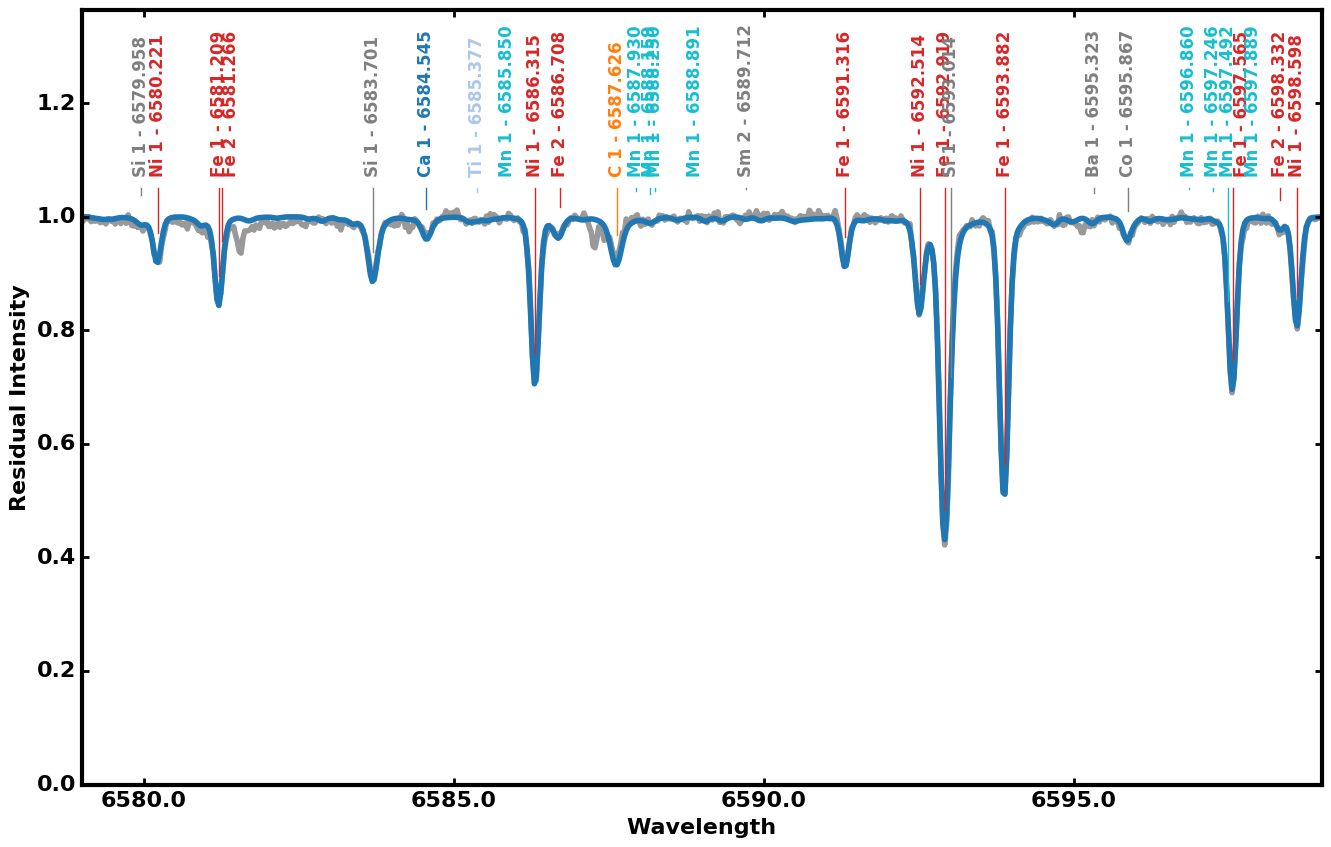

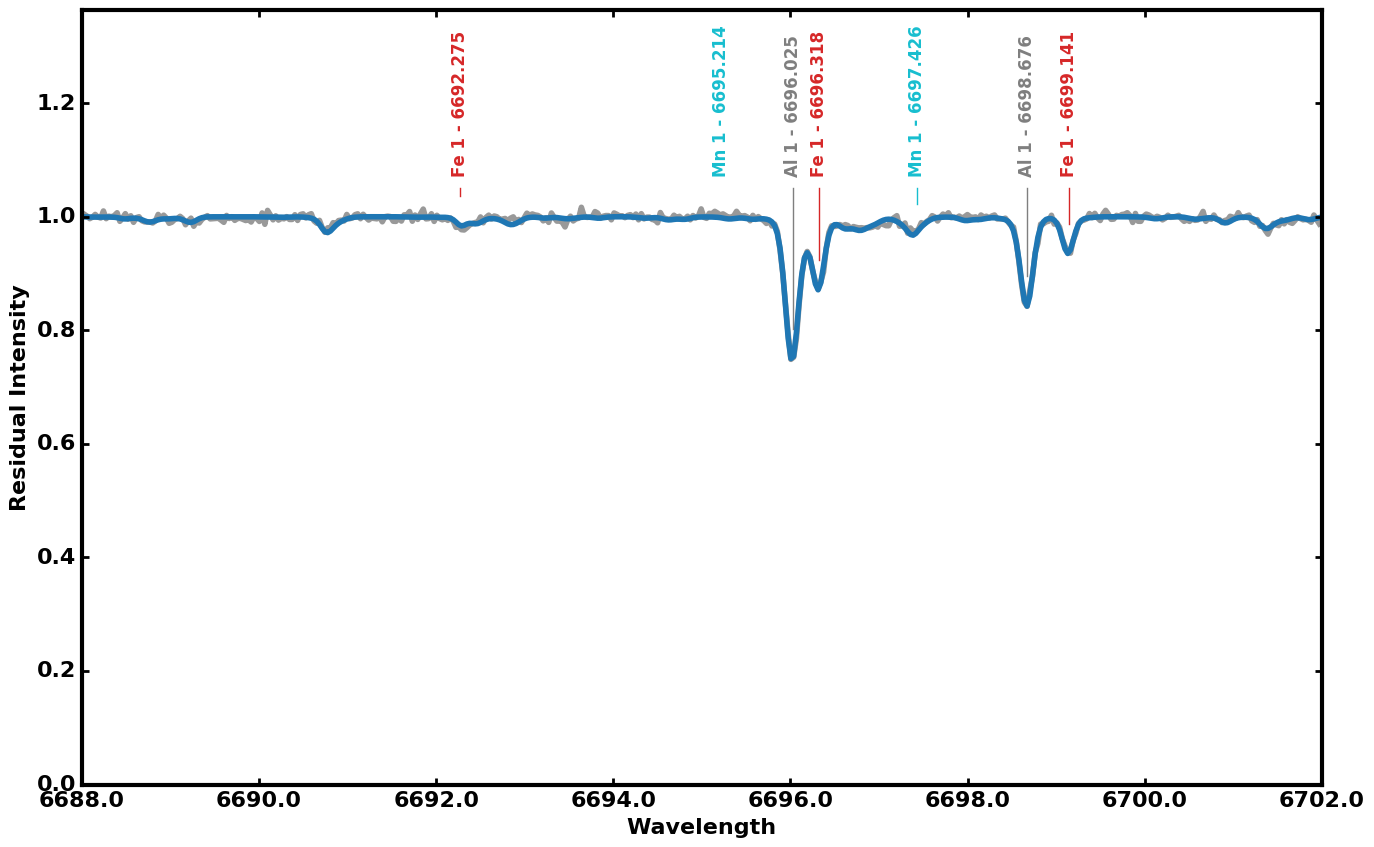

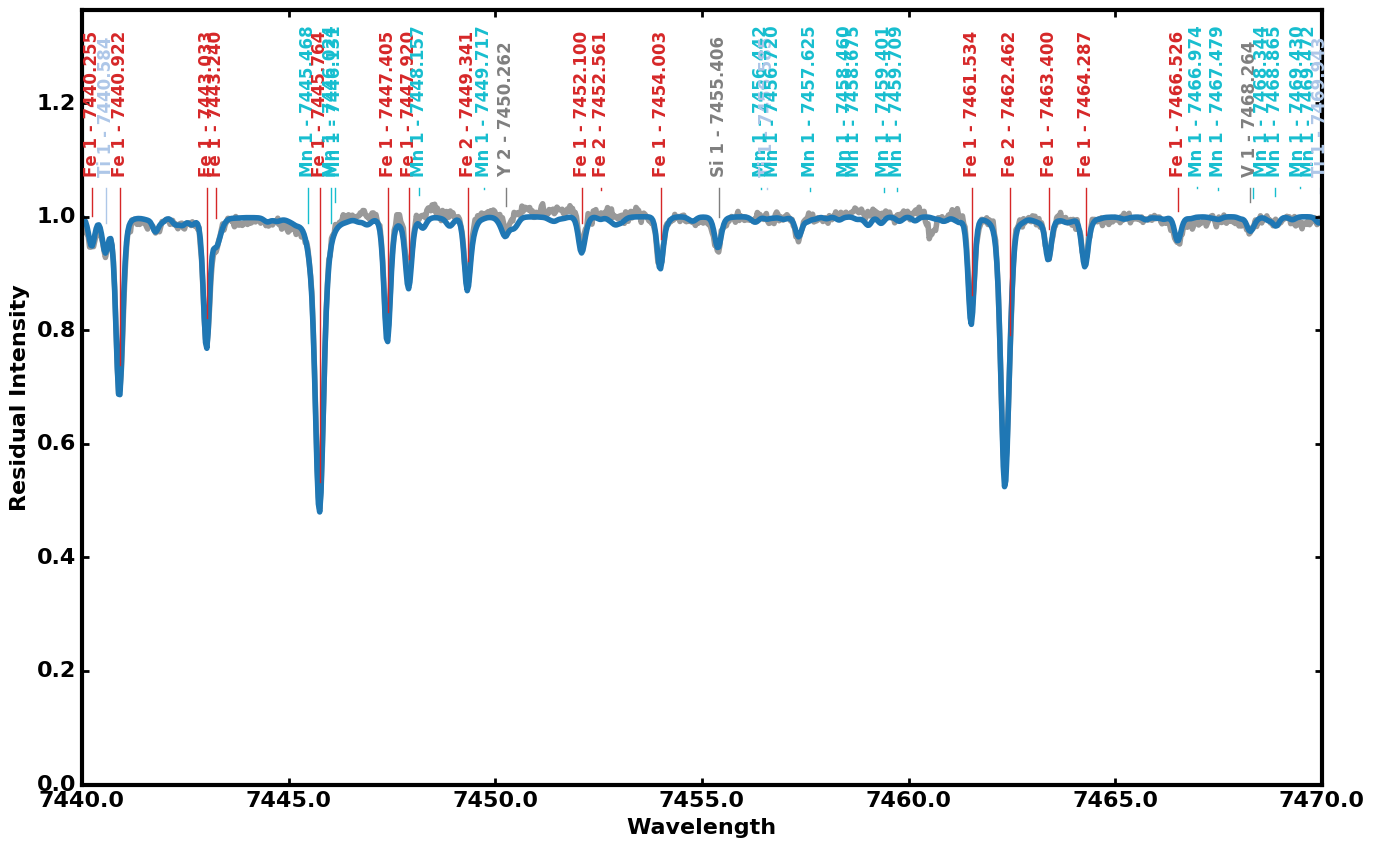

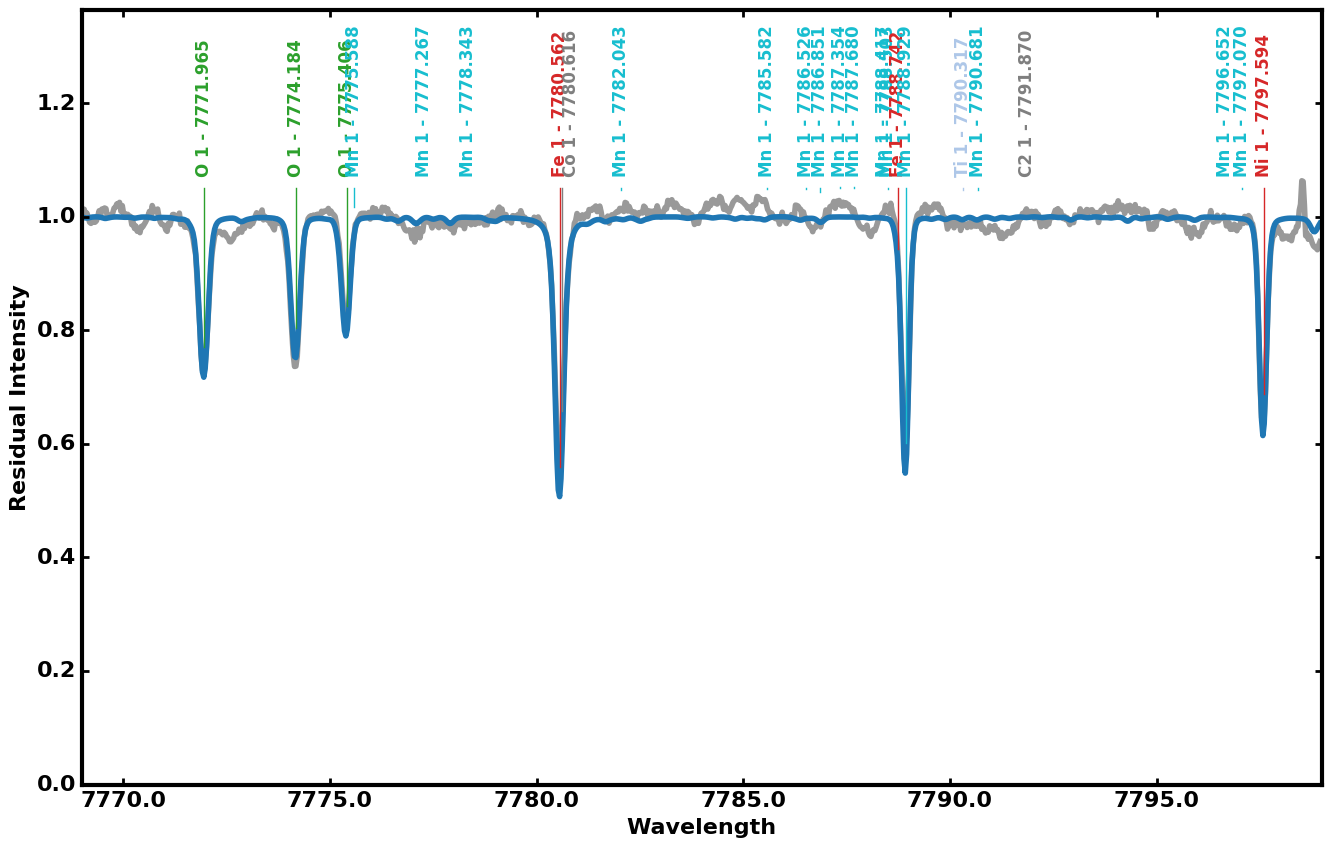

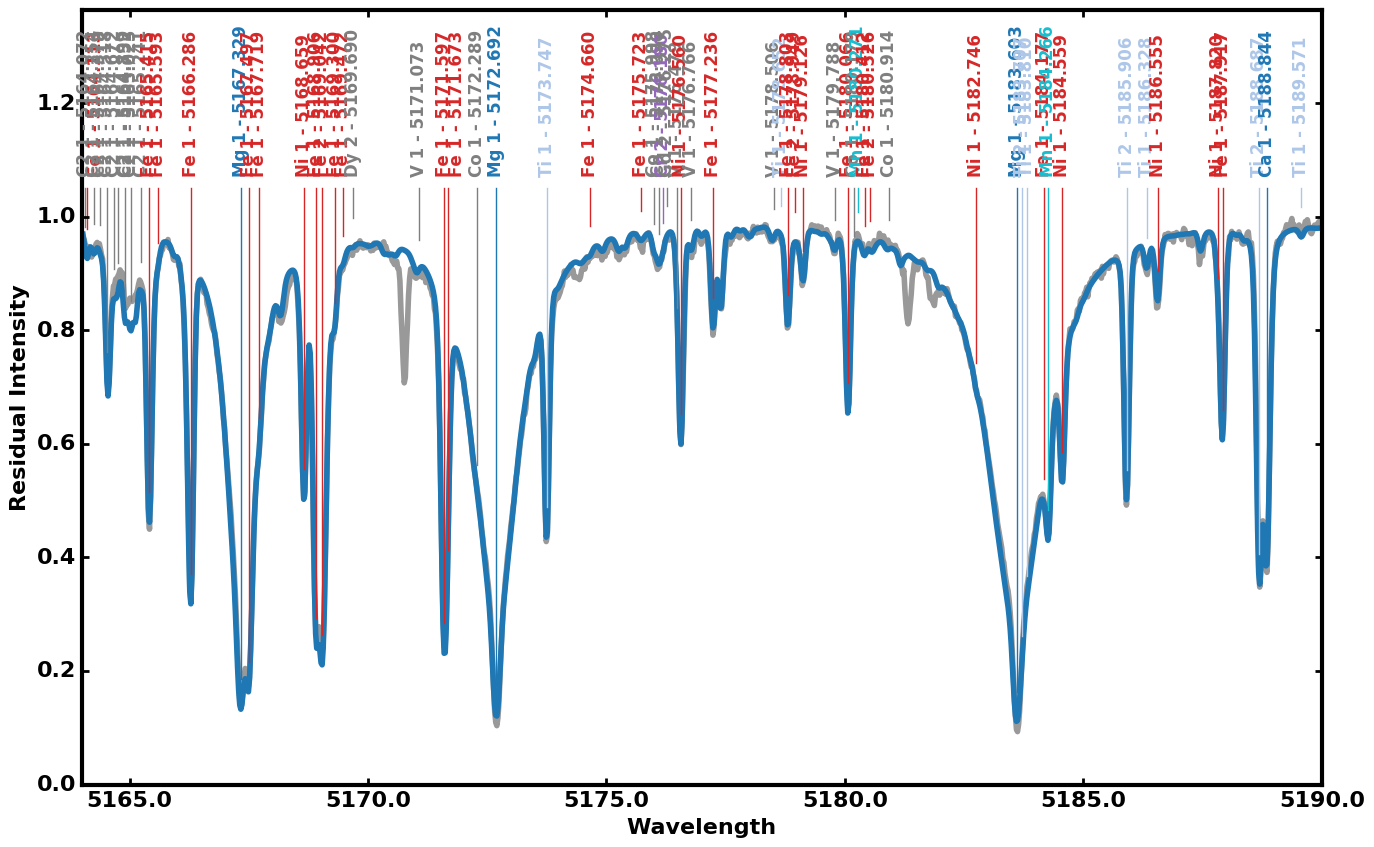

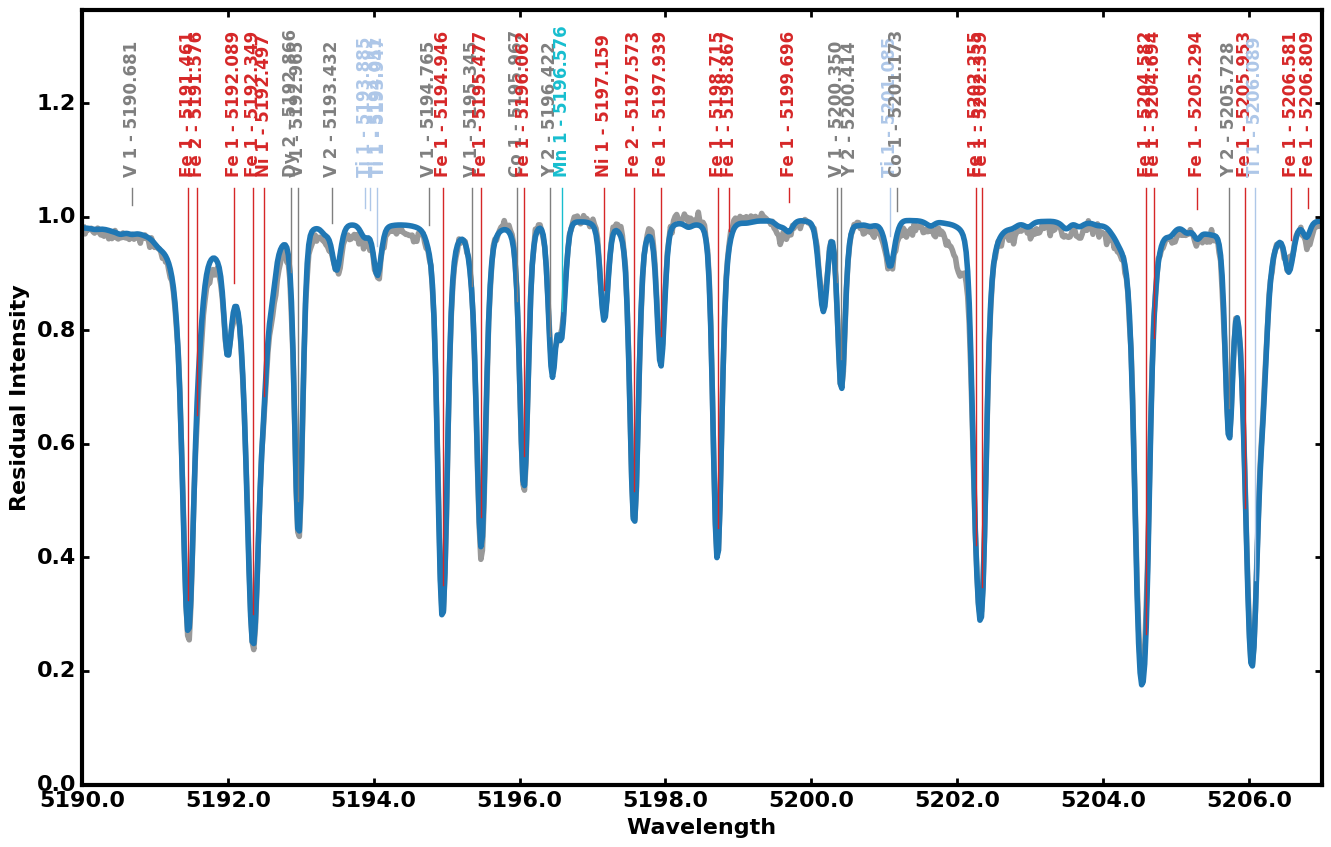

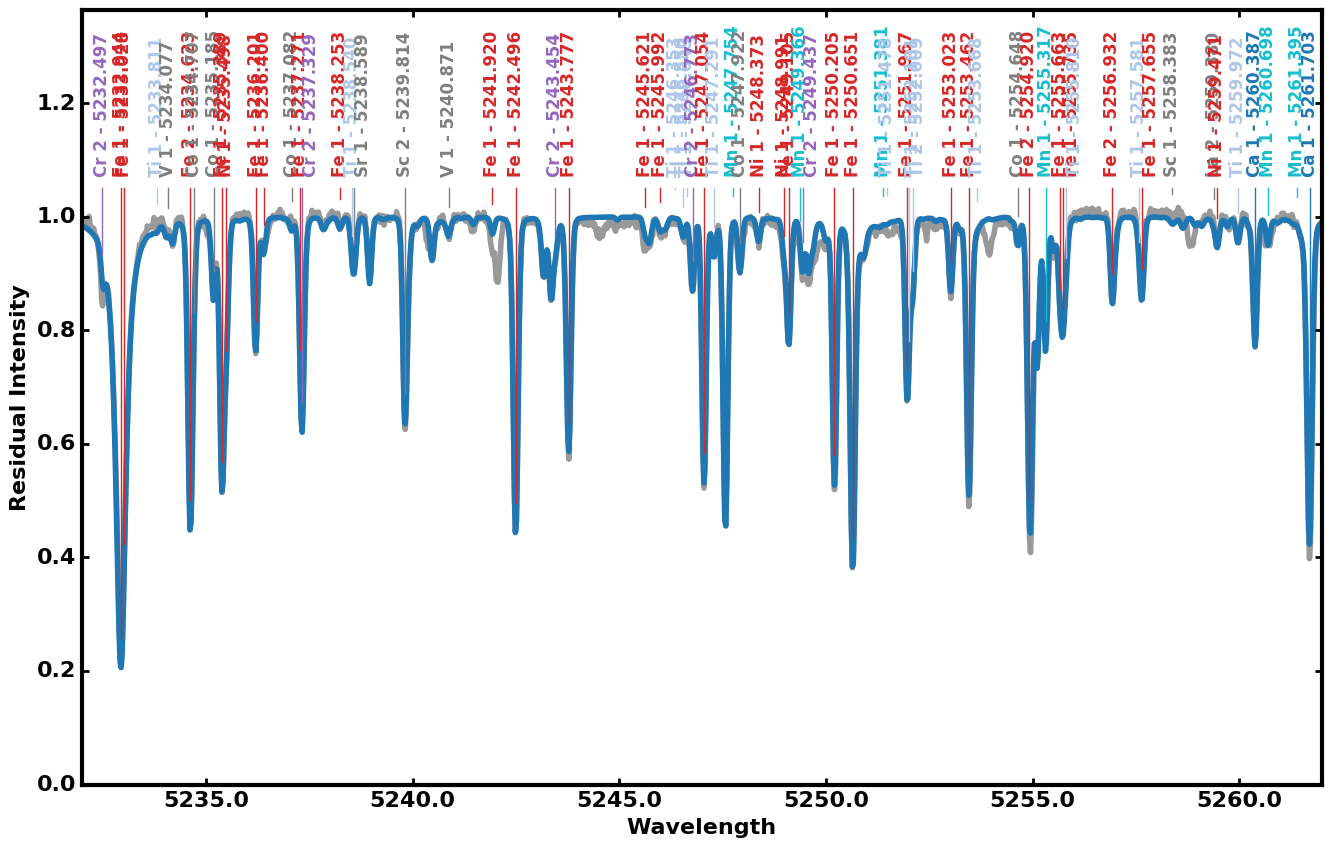

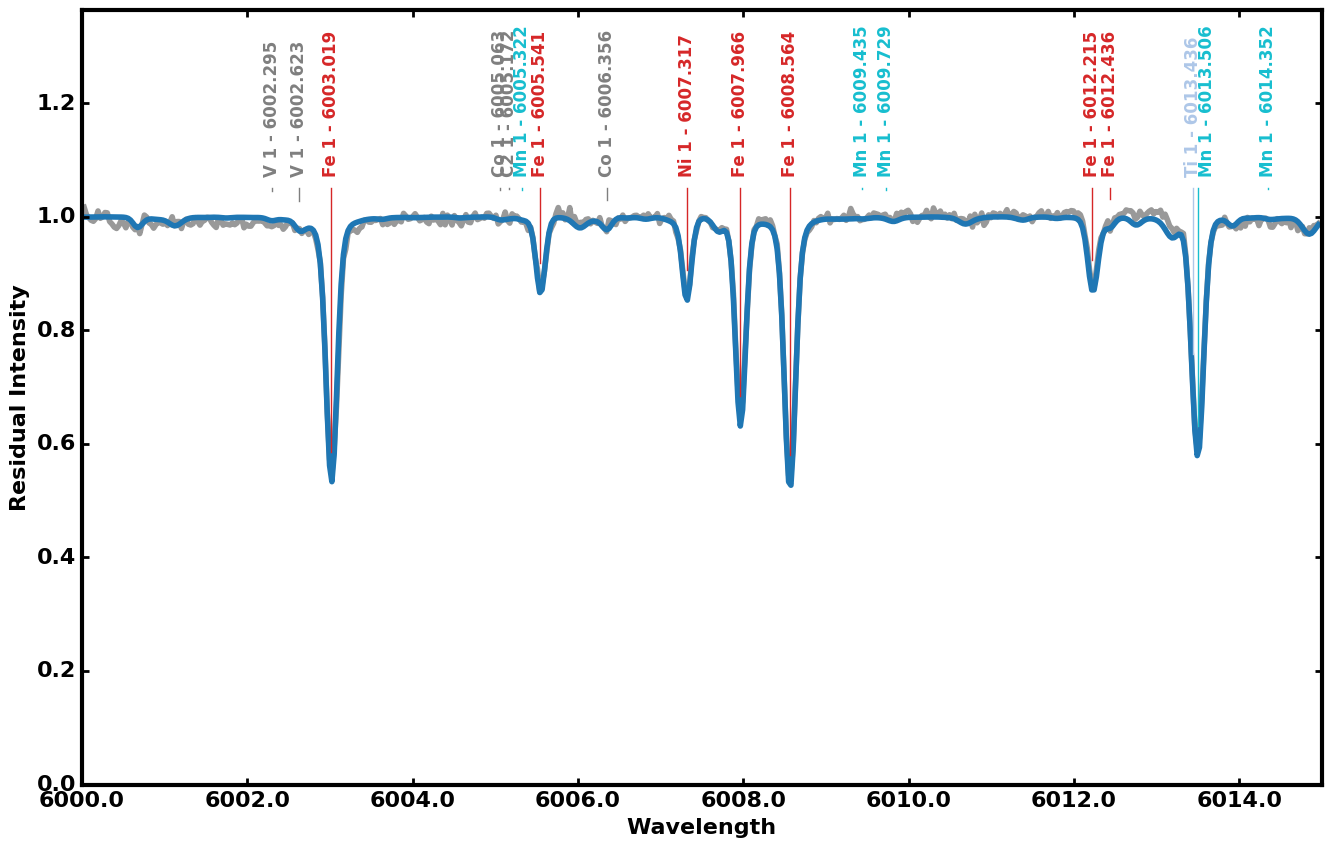

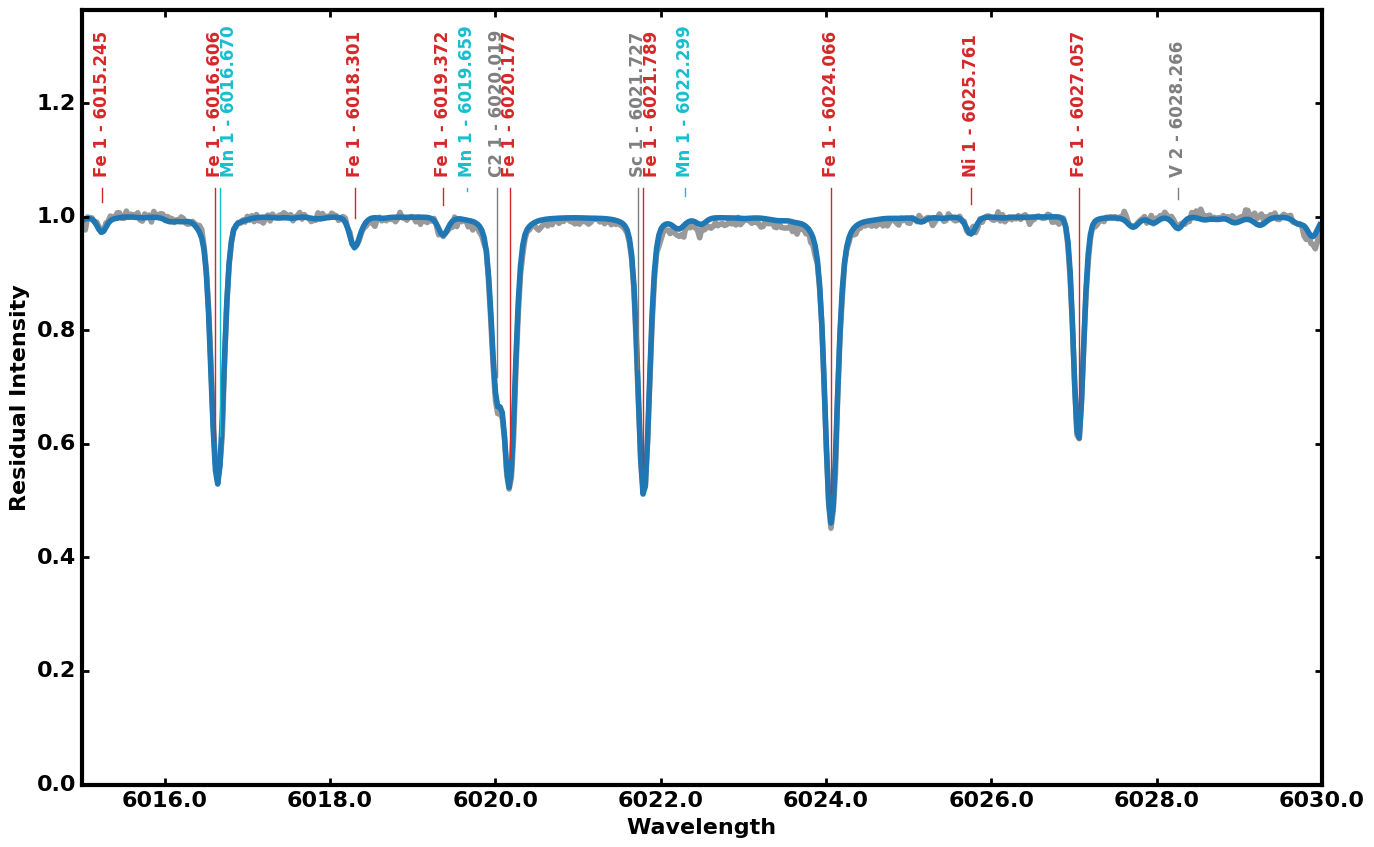

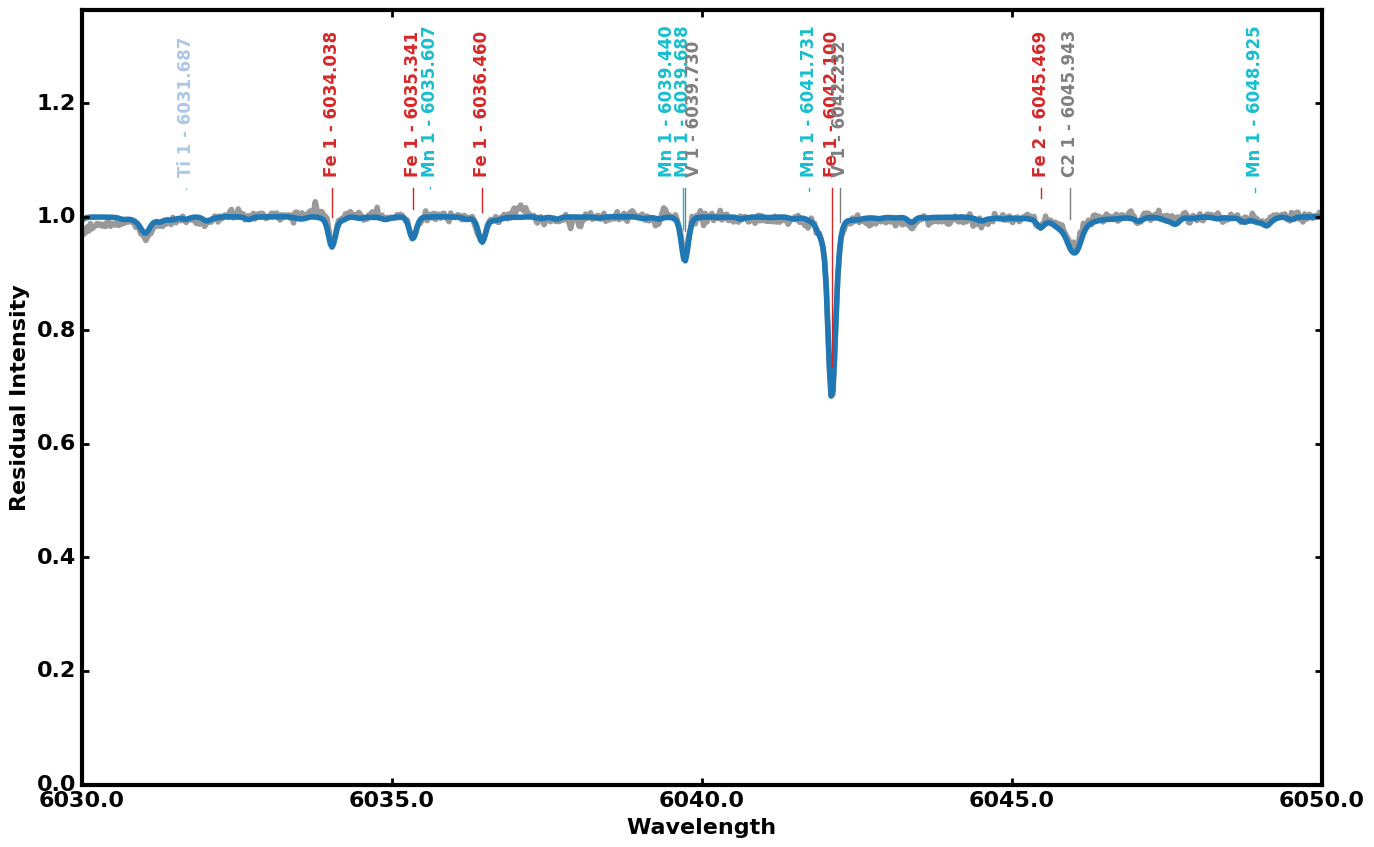

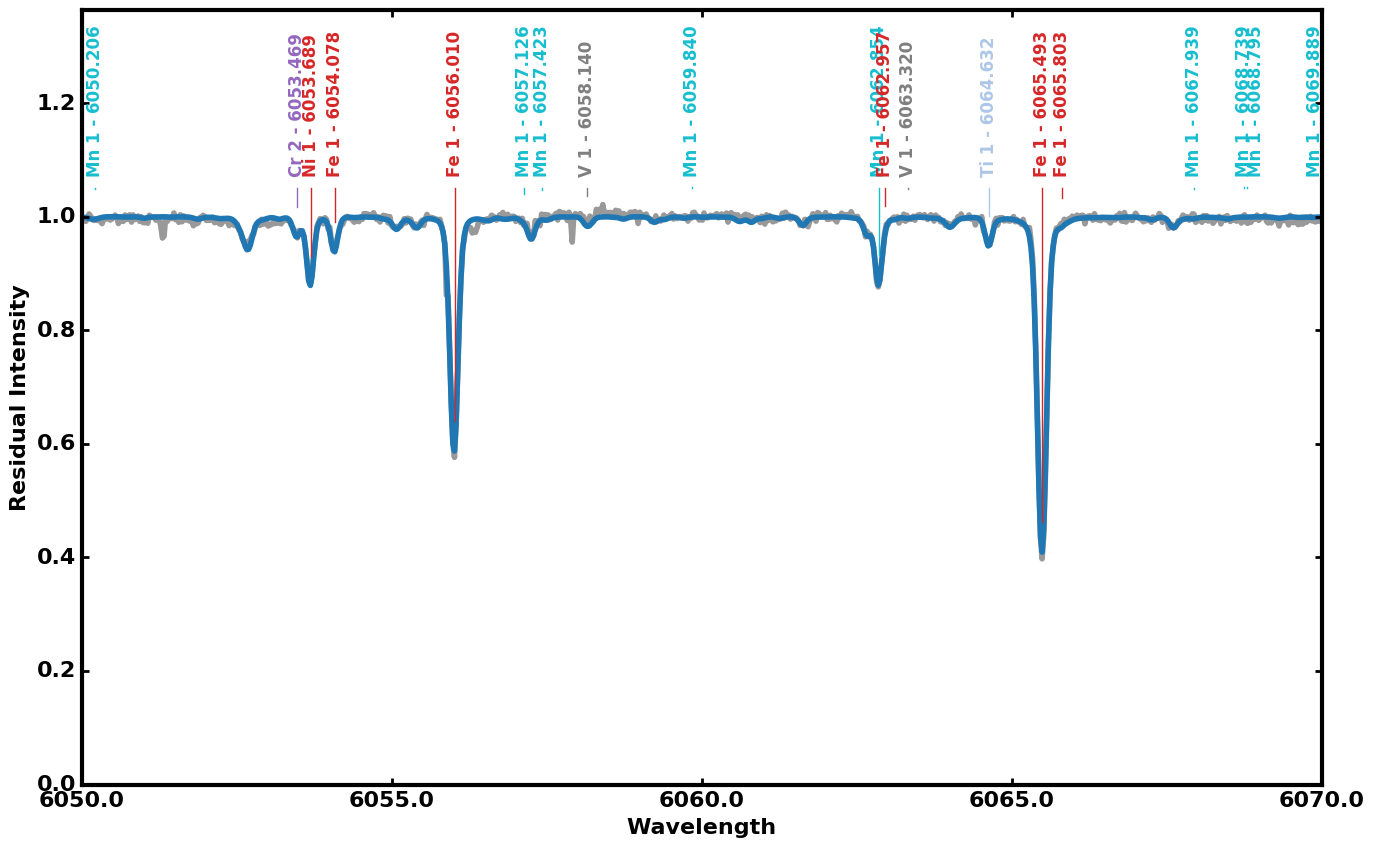

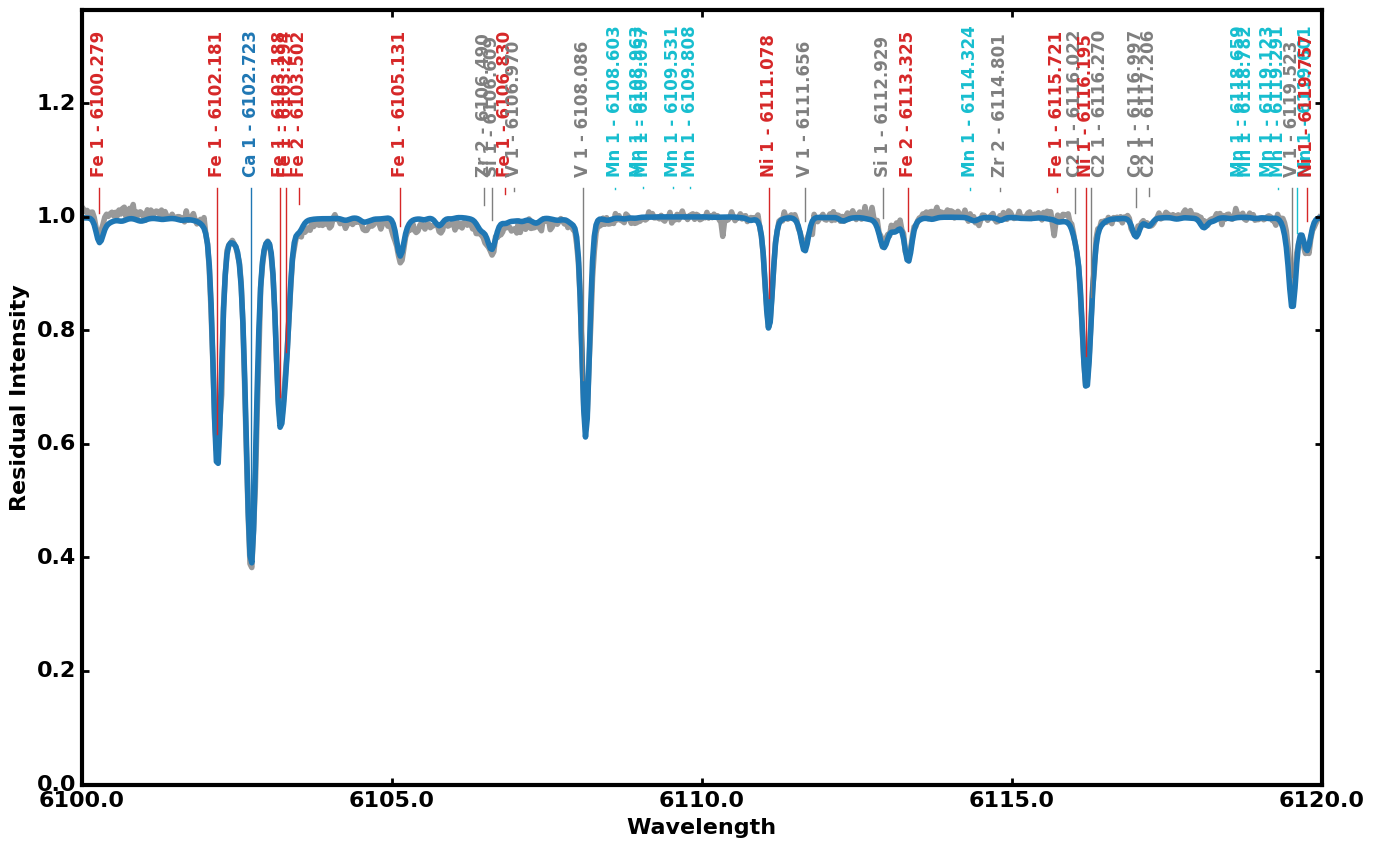

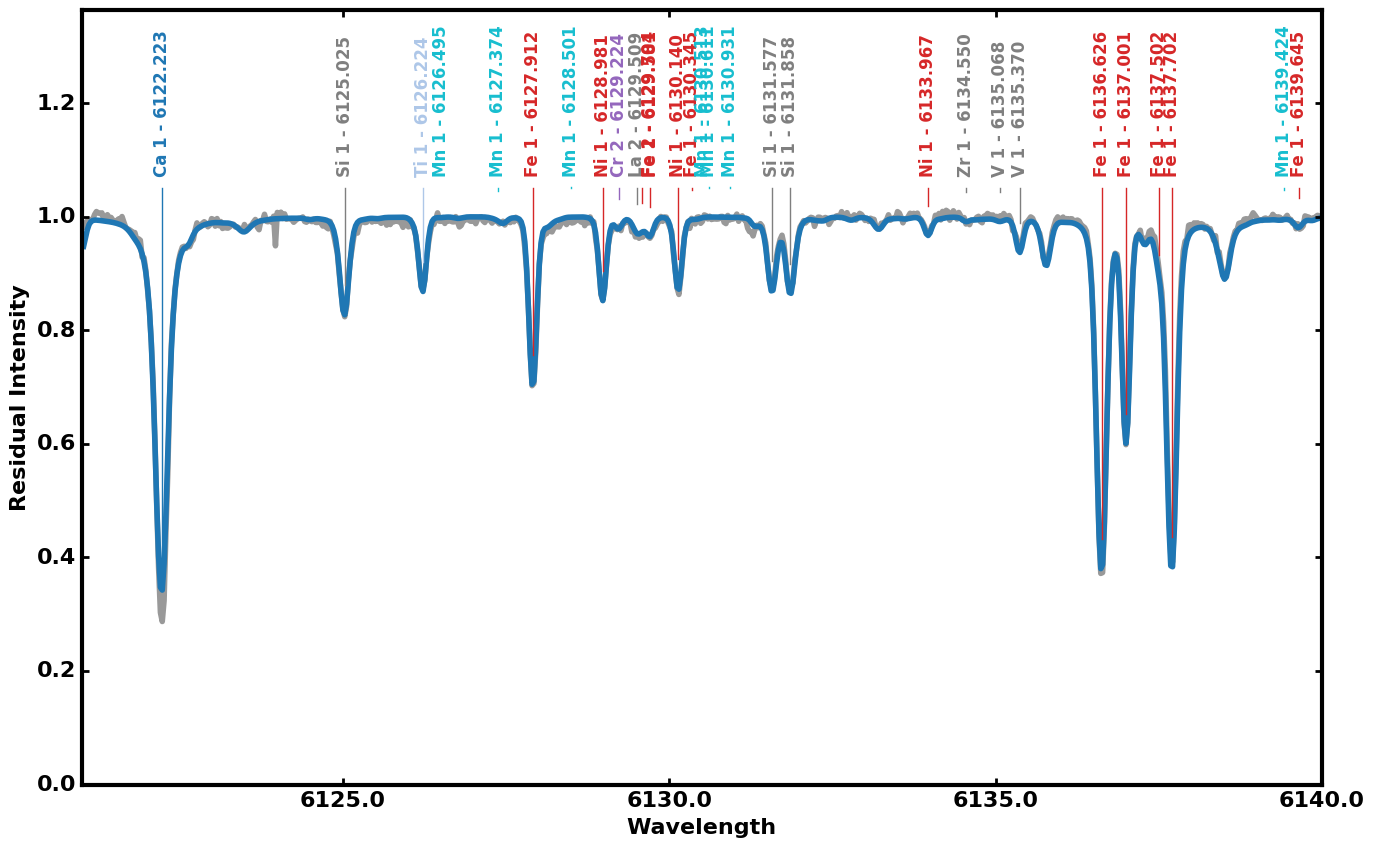

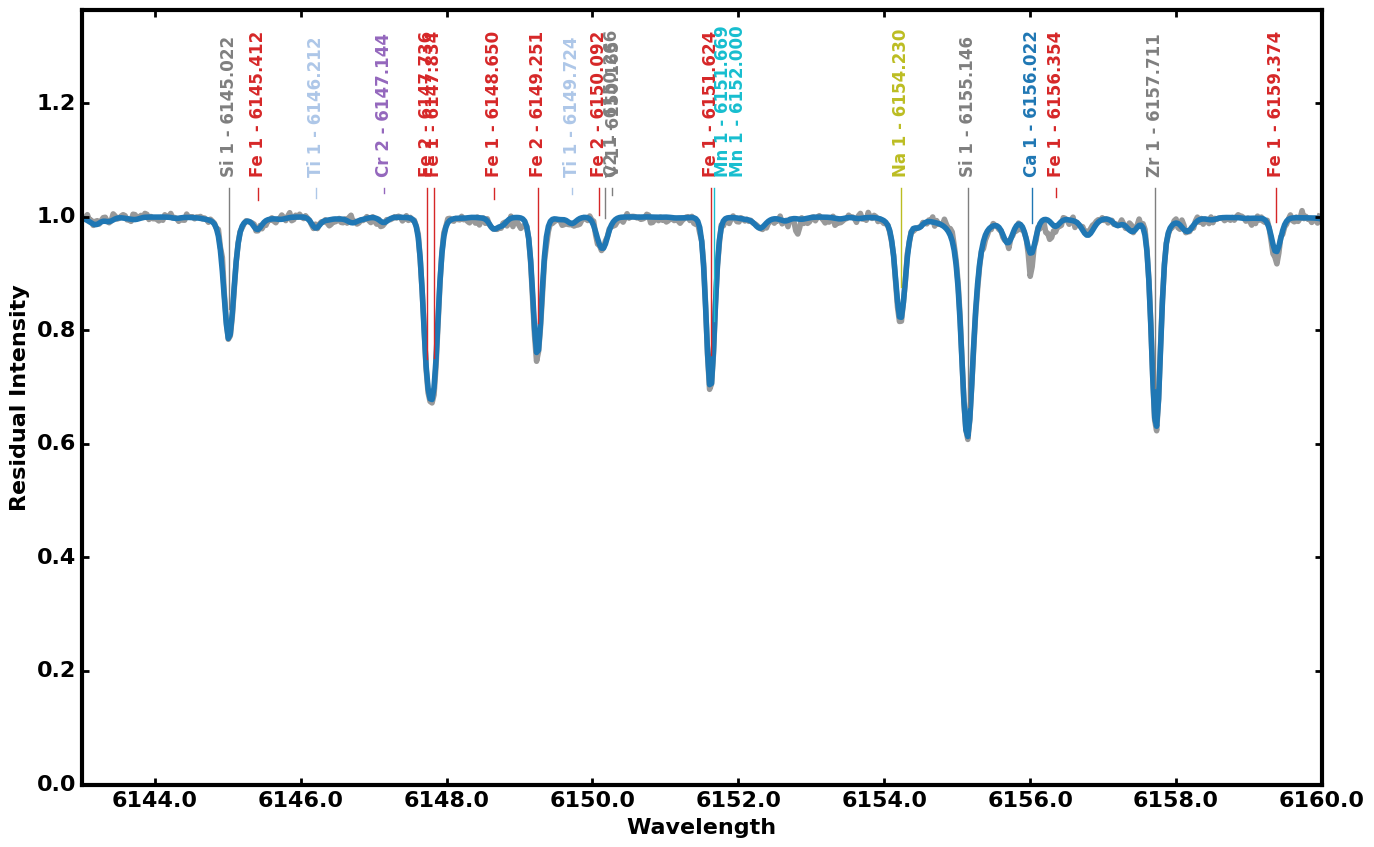

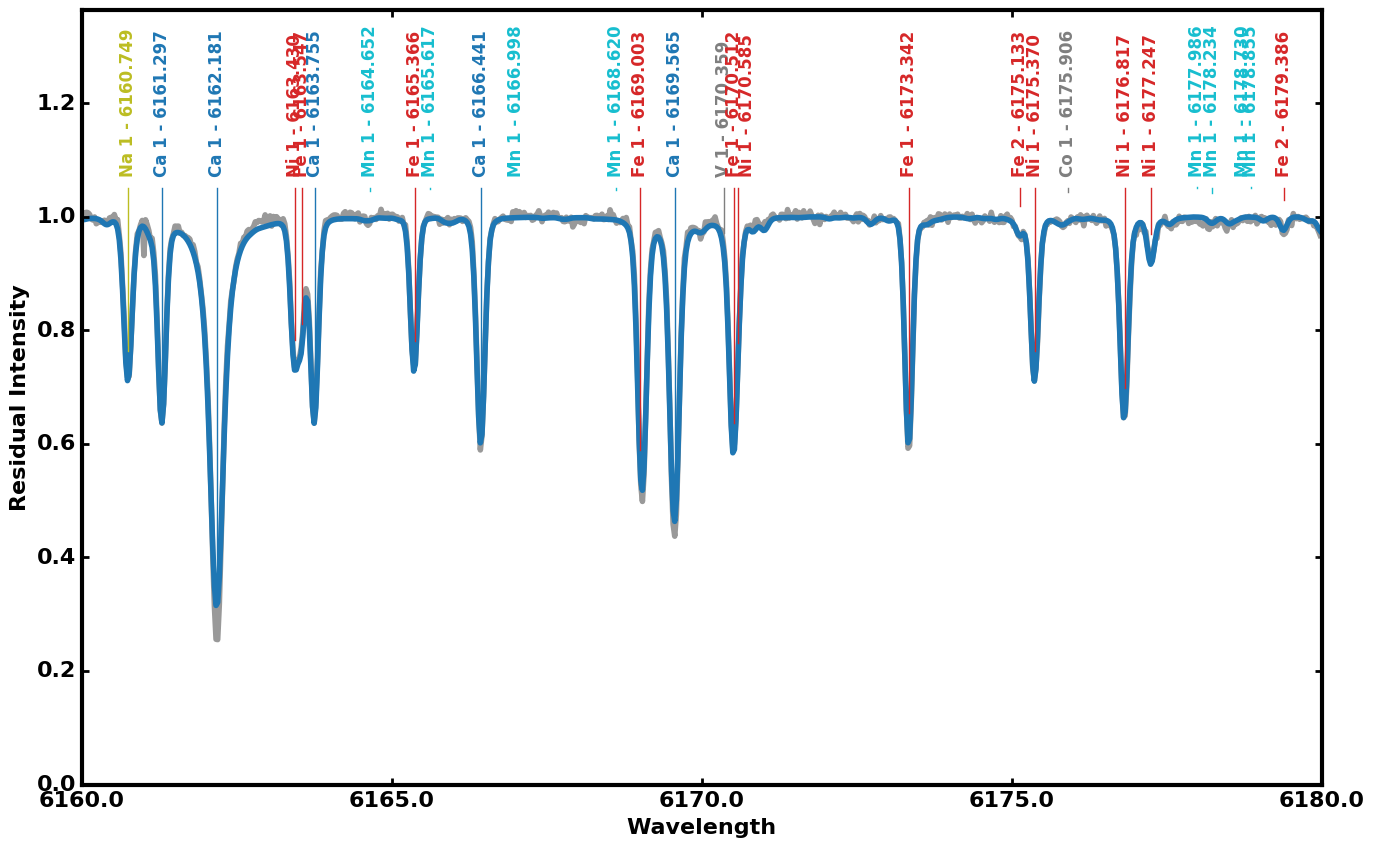

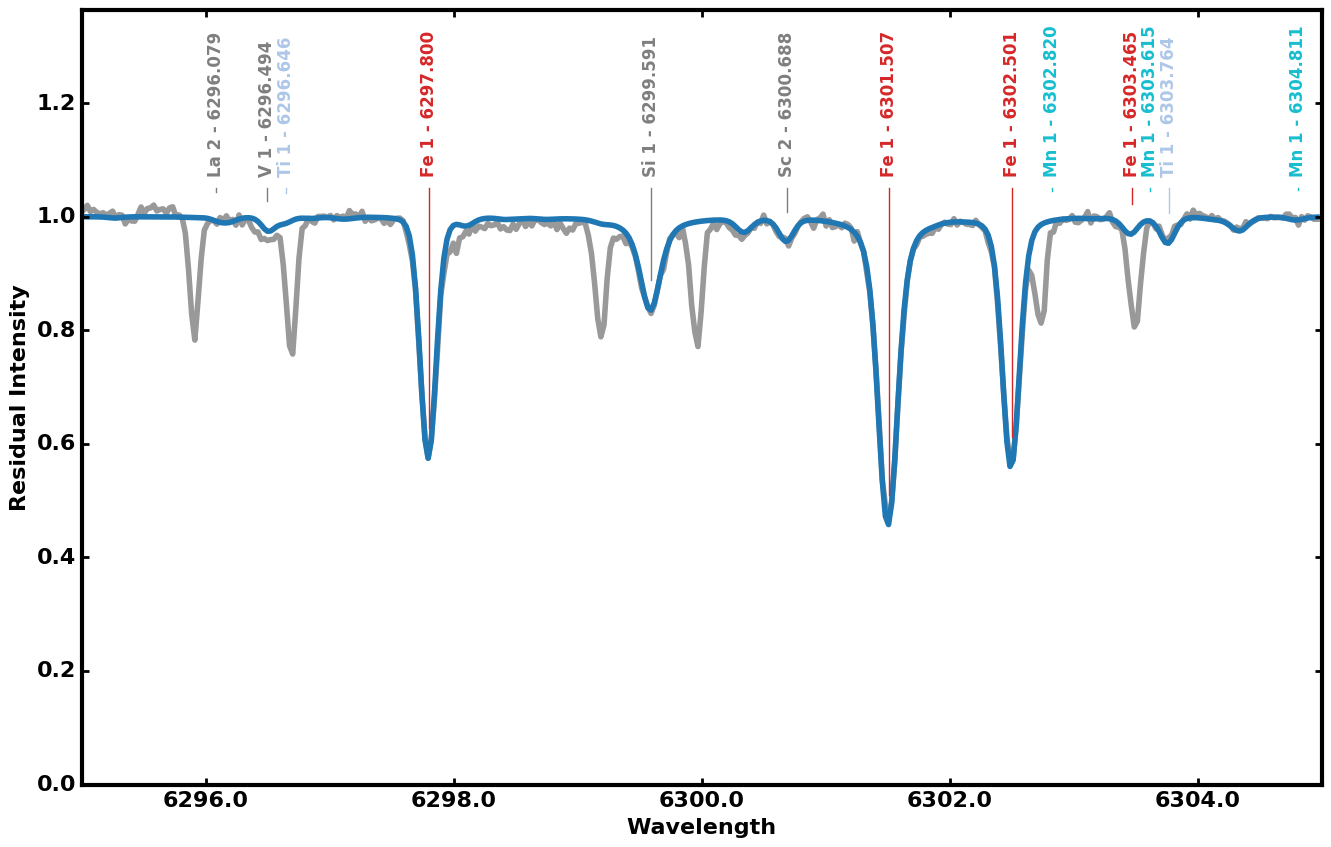

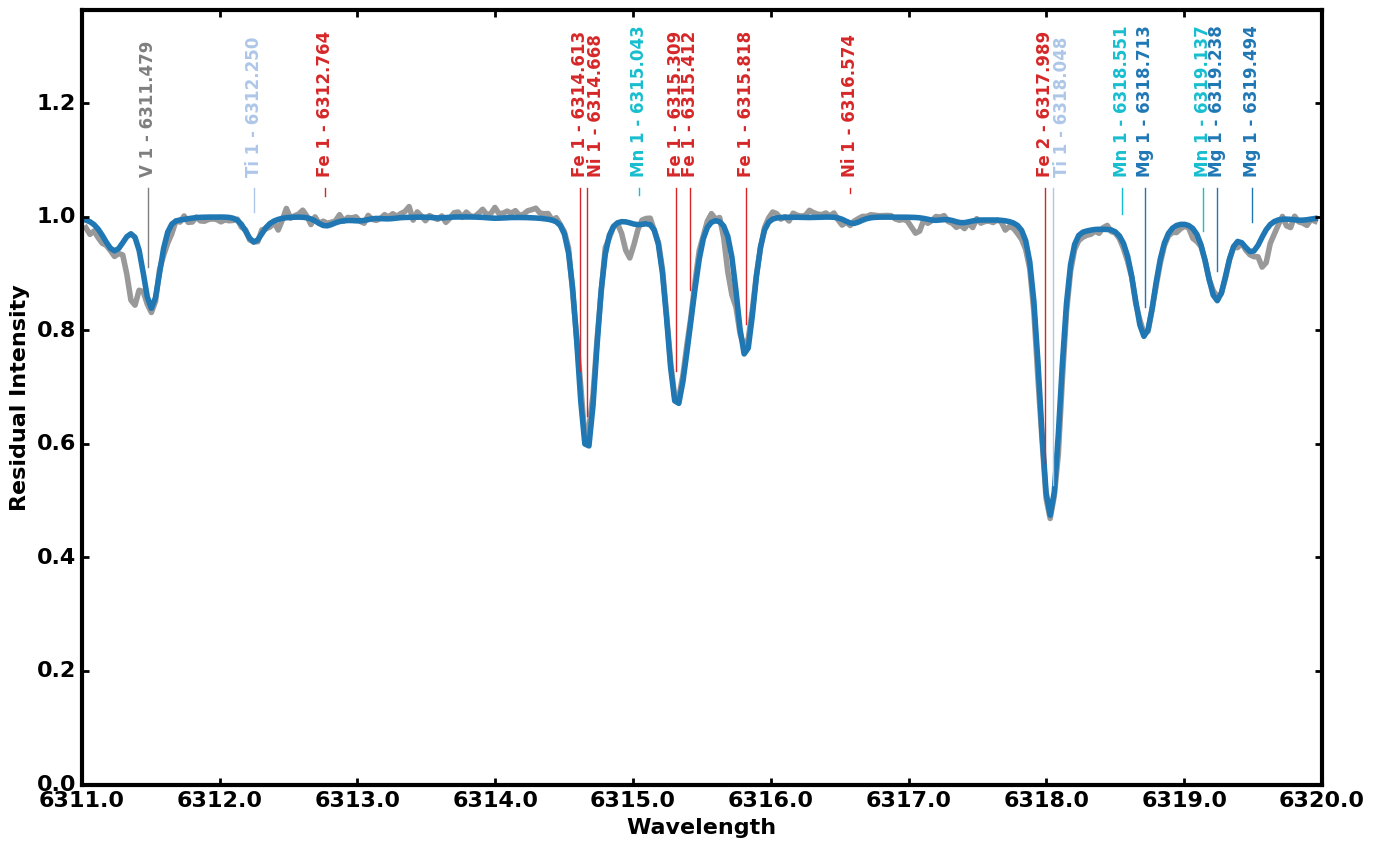

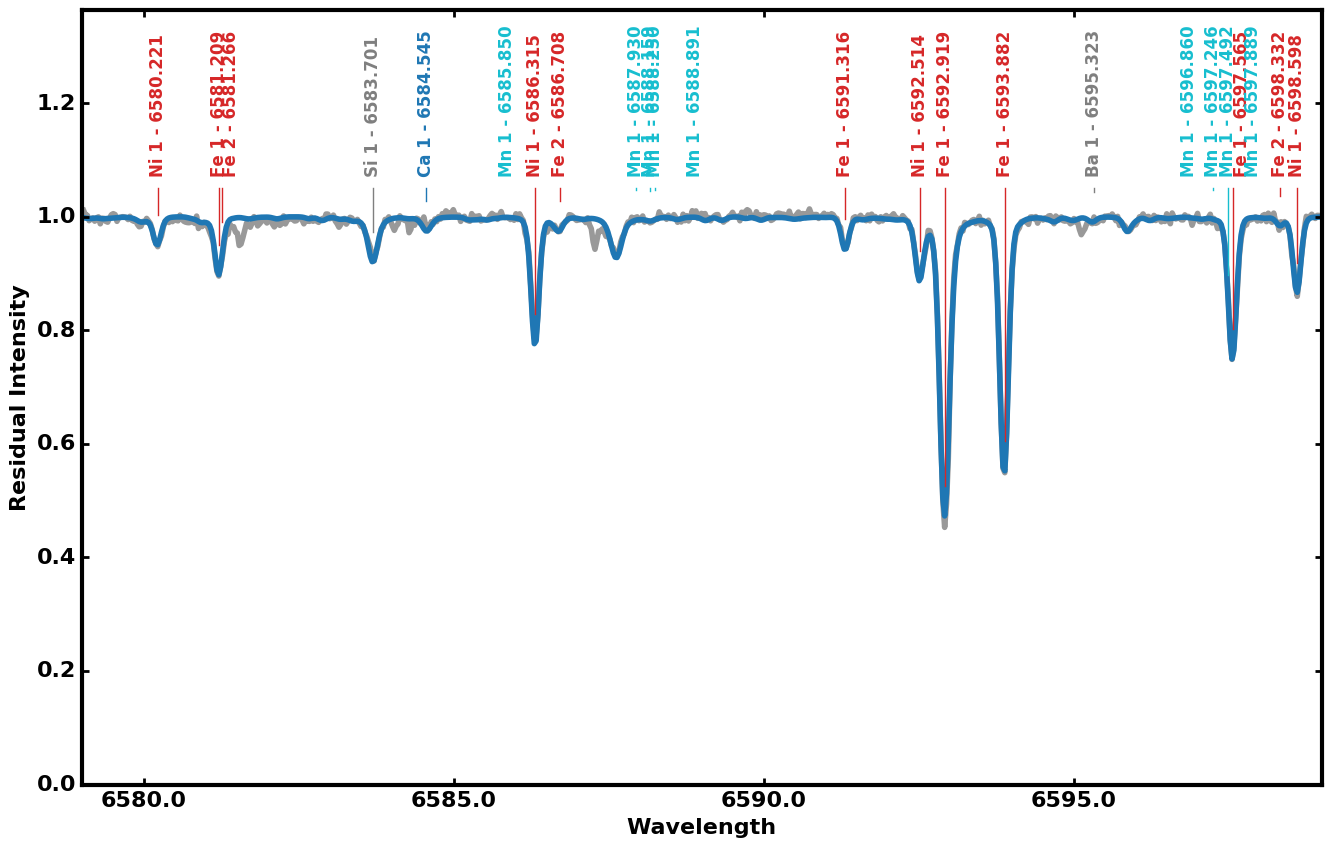

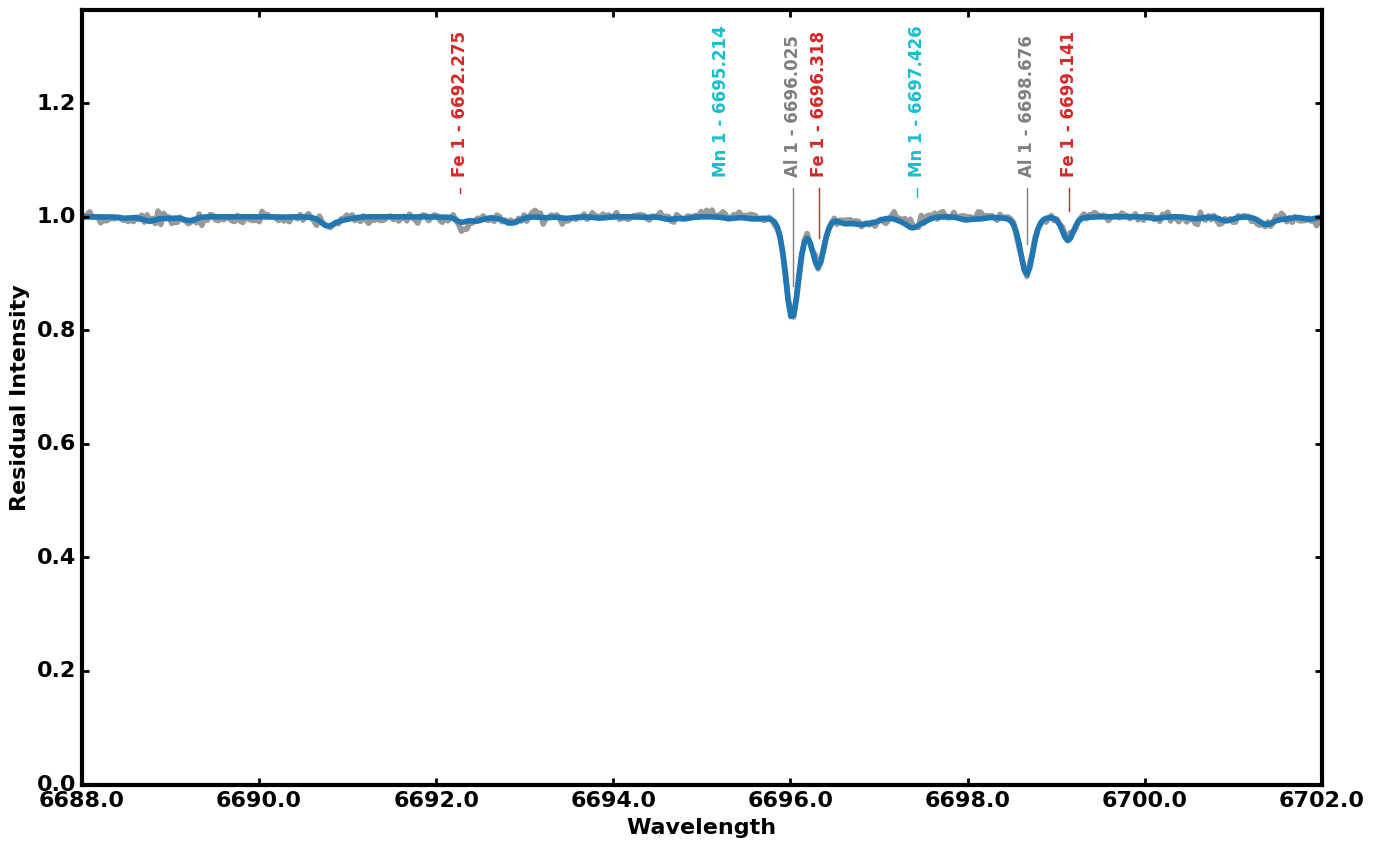

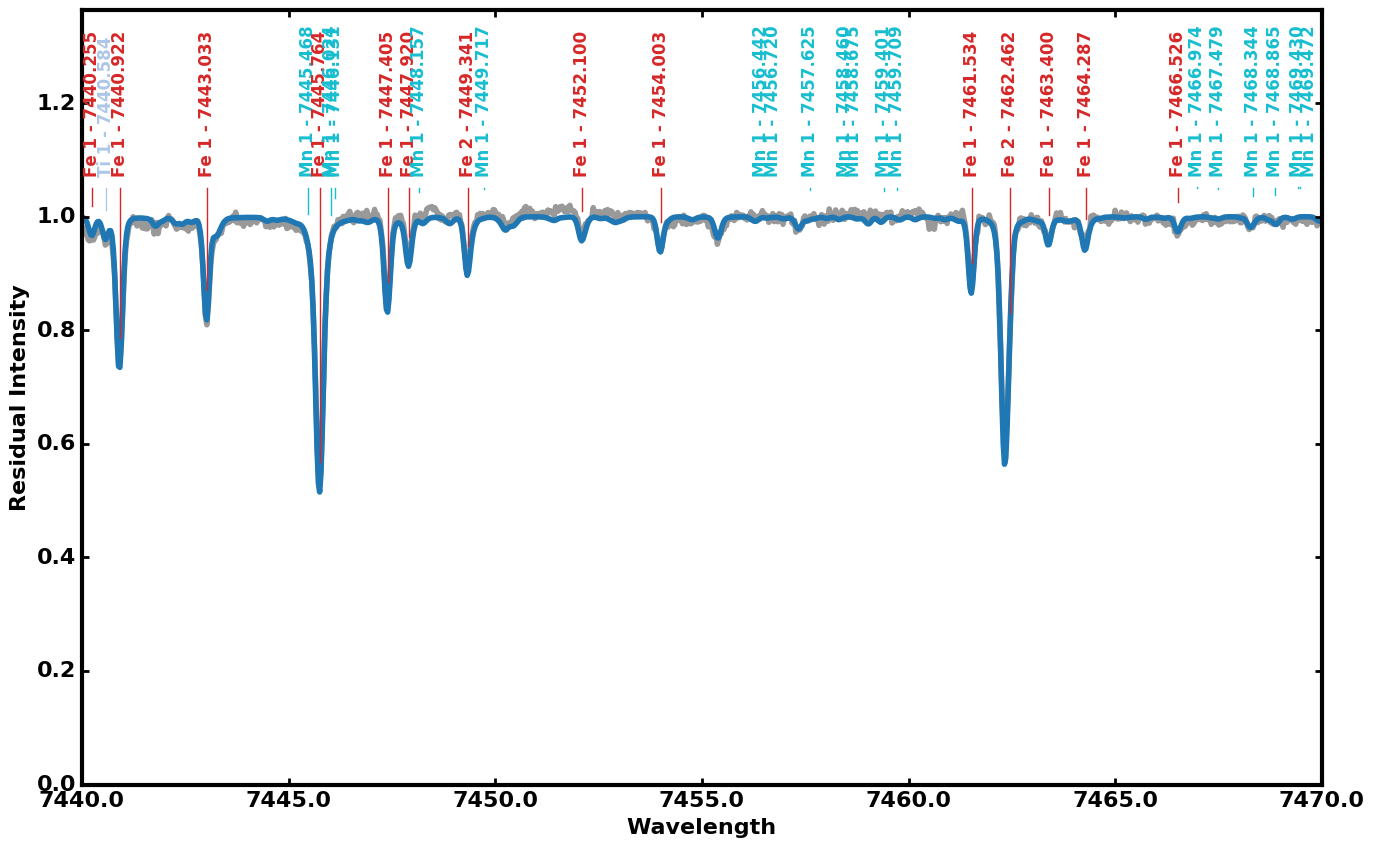

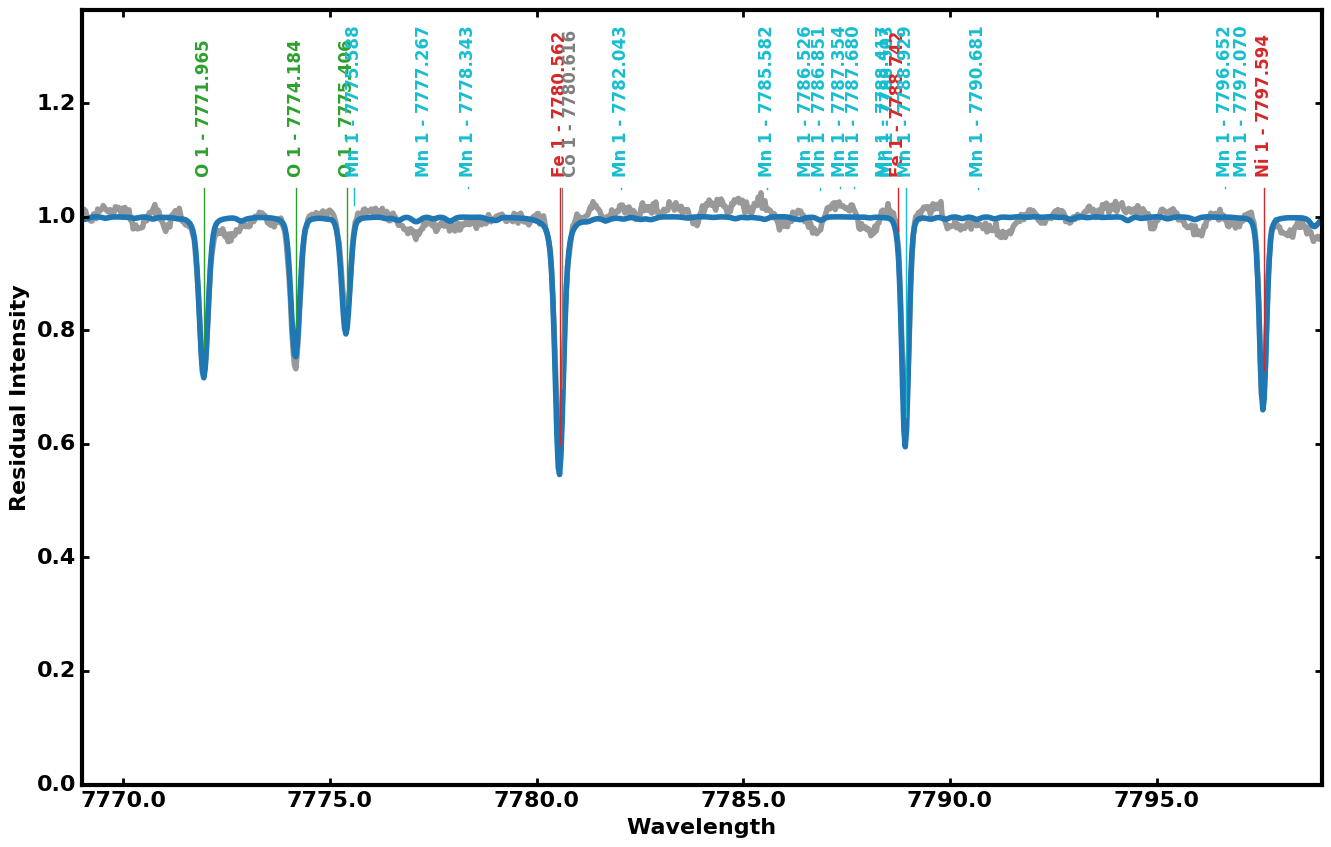

In [8]:
for s in specs:
    smeFile = '{}/iter1_abund.out'.format(s['dir'])
    
    spec = (readsav(smeFile)).sme
    wran = spec.wran[0] # wavelength ranges of segments
    
    for MnSeg,nMnLines in enumerate(segs):
        if nMnLines < 2: continue
        
        waveRange = wran[MnSeg] # specific wavelength range of the segment we wish to plot
        markLines = getLinesToMark(smeFile,MnSeg,'Mn')
        
        f = plotSeg( spec, segIdx=0, wRange=waveRange, showLines=markLines, ax=None)